In [ ]:
# pip install --user albumentations

## Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Hyperparameter Settting

In [ ]:
CFG = {
    'IMG_SIZE': 224,
    'EPOCHS': 5,
    'LEARNING_RATE': 3e-4,
    'BATCH_SIZE': 32,
    'SEED': 41
}

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed) ##random module의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed) #해시 함수의 랜덤성 제어, 자료구조 실행할 때 동일한 순서 고정
    np.random.seed(seed) #numpy 랜덤 숫자 일정
    torch.manual_seed(seed) # torch라이브러리에서 cpu 텐서 생성 랜덤 시드 고정
    torch.cuda.manual_seed(seed) # cuda의 gpu텐서에 대한 시드 고정
    torch.backends.cudnn.deterministic = True # 백엔드가 결정적 알고리즘만 사용하도록 고정
    torch.backends.cudnn.benchmark = True # CuDNN이 여러 내부 휴리스틱을 사용하여 가장 빠른 알고리즘 동적으로 찾도록 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content

/content


In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/deeplearning/open.zip"

## Train & Validation Split

In [ ]:
df = pd.read_csv('./train.csv')
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

## Label-Encoding

In [ ]:
le = preprocessing.LabelEncoder() # 라벨인코딩 /라벨(목표 변수)를 정수로 인코딩
# train, label의 라벨인코딩 과정 진행
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

## CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img  # 라벨을 반환하지 않음




## Model Define

In [ ]:
import os

# 이미지 파일 경로와 레이블을 자동으로 매기기 위한 함수
def generate_dataset_from_directory(directory):
    image_paths = []
    labels = []

    # 디렉토리 내 모든 이미지 파일 경로 추가
    image_files = os.listdir(directory)

    # 이미지 파일 경로와 레이블을 추가
    for image_name in image_files:
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # 확장자 확인
            image_paths.append(os.path.join(directory, image_name))
            # 레이블을 자동으로 매기기 (예시: 0부터 시작)
            label = int(image_name.split('_')[1].split('.')[0]) % 5  # 예시로 숫자 추출하여 레이블 할당
            labels.append(label)

    return image_paths, labels

# 훈련 데이터셋 경로
train_directory = '/content/train'

# 이미지 경로와 레이블 생성
train_data, train_labels = generate_dataset_from_directory(train_directory)

# 생성된 경로와 레이블 확인
print(train_data[:5])  # 앞의 5개 경로 출력
print(train_labels[:5])  # 앞의 5개 레이블 출력


['/content/train/TRAIN_14693.jpg', '/content/train/TRAIN_14503.jpg', '/content/train/TRAIN_07859.jpg', '/content/train/TRAIN_04424.jpg', '/content/train/TRAIN_15618.jpg']
[3, 3, 4, 4, 3]


In [ ]:
# 학습 데이터를 준비하고 DataLoader 정의
train_dataset = CustomDataset(train_data, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
import os
from torchvision import datasets
from PIL import Image

# 이미지 파일 경로와 레이블을 자동으로 매기기 위한 함수
def generate_dataset_from_directory(directory):
    image_paths = []
    labels = []

    # 디렉토리 내 모든 서브 폴더(클래스) 탐색
    class_names = os.listdir(directory)

    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)

        if os.path.isdir(class_folder):
            # 클래스 폴더 내의 모든 이미지 파일 경로 추가
            for image_name in os.listdir(class_folder):
                if image_name.endswith('.jpg') or image_name.endswith('.png'):  # 확장자 확인
                    image_paths.append(os.path.join(class_folder, image_name))
                    labels.append(class_idx)  # 해당 폴더의 인덱스를 레이블로 사용

    return image_paths, labels

# 훈련 데이터셋 경로
train_directory = '/content/train'

# 이미지 경로와 레이블 생성
train_data, train_labels = generate_dataset_from_directory(train_directory)

# 생성된 경로와 레이블 확인
print(train_data[:5])  # 앞의 5개 경로 출력
print(train_labels[:5])  # 앞의 5개 레이블 출력


[]
[]


In [ ]:
class MultiInputModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(MultiInputModel, self).__init__()
        self.low_res_backbone = models.efficientnet_b0(pretrained=True)  # 저해상도 이미지용 백본
        self.high_res_backbone = models.efficientnet_b4(pretrained=True)  # 업스케일 이미지용 백본
        self.classifier = nn.Linear(1000 * 2, num_classes)  # 두 모델의 출력 결합 후 분류기

    def forward(self, low_res, high_res):
        low_res_features = self.low_res_backbone(low_res)
        high_res_features = self.high_res_backbone(high_res)
        combined_features = torch.cat((low_res_features, high_res_features), dim=1)  # 특성 결합
        out = self.classifier(combined_features)
        return out


In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    best_score = 0
    best_model = None

    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []

        for imgs, upscale_imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            upscale_imgs = upscale_imgs.float().to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            output = model(imgs, upscale_imgs)  # 두 이미지를 모델에 입력
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_score = validation(model, criterion, val_loader, device)
        train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss: [{train_loss:.5f}], Val Loss: [{val_loss:.5f}], Val F1 Score: [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step(val_score)

        if best_score < val_score:
            best_score = val_score
            best_model = model

    return best_model

In [ ]:
class BaseModel(nn.Module):
    #le.classes는 LabelEncoder가 학습한 후에 갖게되는 속성 (고유한 클래스 라벨들의 배열)
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        # EfficientNet B0 아키텍처를 사용하여 사전 훈련된 백본 설정. 특성 추출기 역함
        self.backbone = models.efficientnet_b0(pretrained=True)

### 여기를 컨볼루션으로 바꾸든 모델 바꿔서 성능 올리기

        # 백본 모델의 출력을 받아 최종적으로 클래스 수에 맞는 출력을 생성하는 선형 분류기
        self.classifier = nn.Linear(1000, num_classes) #기본 출력크기 1,000으로 정의

    def forward(self, x):
        x = self.backbone(x) #backbone을 거쳐 특성이 추출
        x = self.classifier(x) # 분류기에 전달되어 최종 출력 생성
        return x

In [ ]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(ConvModel, self).__init__()

        # Convolutional Layers (특성 추출)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Max Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # 배치 정규화 (Batch Normalization)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        # Linear layer (fully connected)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)  # 이미지 크기 224x224 -> 8x8로 크기 축소됨 (max pool 두 번)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # 첫 번째 컨볼루션 + 배치 정규화 + ReLU + MaxPool
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # 두 번째 컨볼루션 + 배치 정규화 + ReLU + MaxPool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # 세 번째 컨볼루션 + 배치 정규화 + ReLU + MaxPool
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # 1D 텐서로 평탄화 (Flatten)
        x = torch.flatten(x, 1)  # 배치 크기를 제외한 나머지 차원들을 평탄화

        # 완전 연결층 (fully connected)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device) # 모델을 해당 디바이스로 옮김(cpu, gpu)
    criterion = nn.CrossEntropyLoss().to(device) # 손실함수 정의하고 해당 device로 옮김

    # 성능 기록 초기화
    best_score = 0
    best_model = None

    # 설정한 하이퍼파라미터의 epochs만큼 반복
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train() #모델을 훈련모드로 설정
        train_loss = []

        # 반복을 통해서 배치 단위로 이미지와 라벨을 가져옴
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device) # 이미지를 실수형으로 변경한 후 device로 올림
            labels = labels.long().to(device)  # 데이터 타입 long으로 변경한 후 device로 올림 (int로 변경하였을 때, error 발생했음)

            optimizer.zero_grad() # 이전 그레디언트가 누적될 가능성이 있으니 초기화

            output = model(imgs) # 모델의 이미지를 입력하여 출력을 얻음
            loss = criterion(output, labels) # 손실 함수를 통해 손실 값을 계산함.

            loss.backward() # 손실에 대한 그레디언트 계산
            optimizer.step() # 옵티마이저를 통해 모델의 가중치 업데이트

            train_loss.append(loss.item()) # loss.item()은 현재 배치에 대한 손실 값을 파이썬의 floate 타입으로 변환.
            # 훈련 과정에서 각 배치를 처리할 때마다 이 줄이 실행되어, 각 배치의 손실 값을 train_loss 리스트에 순차적으로 추가

        # 각 에포크마다 validation함수를 호출하여서 검증 세트에서 모델의 성능을 평가
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss) # 각 배치에서 계산된 모든 손실 값의 평균을 구함
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 Score : [{_val_score:.5f}]')

        # scheduler이 설정되어 있다면 검증 성능에 따라 학습률을 조정
        if scheduler is not None:
            scheduler.step(_val_score)

        # 가장 좋은 성능을 보인 모델을 반환
        if best_score < _val_score:
            best_score = _val_score
            best_model = model

    return best_model

def validation(model, criterion, val_loader, device):
    model.eval() # 평가모드
    val_loss = []
    preds, true_labels = [], []

    # 평가모드의 경우에는 gradient를 초기화하는 부분이 없음 (backward 필요없음. 오직 평가만!)
    with torch.no_grad(): # 이 블록 내에서 그레디언트 계산을 중단하여, 필요하지 않은 메모리 사용을 줄이고 계산 속도 향상.
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.long().to(device)  # 데이터 타입 long으로 변경한 후 device로 올림 (int로 변경하였을 때, error 발생했음)

            pred = model(imgs)

            loss = criterion(pred, labels)

            # pred는 모델이 반환한 예측값. 각 클래스에 대한 확률 또는 점수를 포함하는 텐서. argmax(1)은 각 샘플에 대해 가장 높은 점수를 가진 클래스의 인덱스를 찾아줌.
            # detach()는 현재 계산 그래프로부터 이 텐서를 분리하여, 이후 연산이 그래프에 기록되지 않도록함. 메모리 사용량 줄임
            # cpu()는 cpu로 옮김 (GPU에 있었다면)
            # numpy()는 텐서를 numpy 배열로 변환
            # tolist()는 numpy 배열을 파이썬 리스트로 변환
            preds += pred.argmax(1).detach().cpu().numpy().tolist()

            # 실제 라벨도 위와 동일한 과정 진행
            true_labels += labels.detach().cpu().numpy().tolist()

            val_loss.append(loss.item())

        _val_loss = np.mean(val_loss)
        # average = 'macro'는 F1점수를 계산할 때, 각 클래스에 대한 F1점수를 동일한 가중치로 평균내어 전체 클래스에 대한 평균 F1점수를 계산.
        # 각 클래스의 샘플 크기와 관계없이 모든 클래스를 동등하게 취급. 이는 클래스 불균형이 있을 때 유용하며, 모든 클래스를 공평하게 평가하고자 할 때 사용.
        _val_score = f1_score(true_labels, preds, average='macro')

    return _val_loss, _val_score


In [ ]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    A.RandomCrop(height=224, width=224, p=0.5),  # Random crop 추가
    A.HorizontalFlip(p=0.5),  # 수평 뒤집기
    A.Rotate(limit=30, p=0.5),  # 회전
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),  # 색상 변화
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # ResNet34 모델을 불러옴
        self.backbone = models.resnet34(pretrained=True)
        # 마지막 fully connected layer를 수정하려면 다음과 같이 할 수 있습니다.
        # self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# 모델 인스턴스 생성
model = MyModel()
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 102MB/s]


MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, preds, class_names):
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
CFG = {
    'IMG_SIZE': 224,
    'EPOCHS': 10,  # 에폭 수 늘리기
    'LEARNING_RATE': 1e-4,  # 더 낮은 학습률 사용
    'BATCH_SIZE': 64,  # 배치 사이즈 늘리기
    'SEED': 41
}

In [ ]:
import os

# 테스트 데이터가 저장된 디렉토리 경로
test_dir = '/content/test'  # 경로를 실제 데이터에 맞게 수정해야 합니다.

# 디렉토리에서 이미지 파일 경로를 읽어옴
test_data = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg') or fname.endswith('.png')]

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data  # 데이터 (이미지 파일 경로와 라벨)
        self.transform = transform  # 변환 (예: 데이터 증강)

    def __len__(self):
        return len(self.data)  # 데이터셋의 크기

    def __getitem__(self, idx):
        image_path, label = self.data[idx]  # 이미지 경로와 라벨

        # 이미지 열기
        image = Image.open(image_path).convert("RGB")

        # transform이 정의되었으면 적용
        if self.transform:
            image = self.transform(image)

        return image, label  # 이미지와 라벨 반환


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
# Instead of importing, directly use the CustomDataset class from the previous cell
#from ipython_input_33_5e73aaa2104f import CustomDataset

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data  # 데이터 (이미지 파일 경로와 라벨)
        self.transform = transform  # 변환 (예: 데이터 증강)

    def __len__(self):
        return len(self.data)  # 데이터셋의 크기

    def __getitem__(self, idx):
        image_path = self.data[idx] # Assuming test_data only contains image paths
        # image_path, label = self.data[idx]  # 이미지 경로와 라벨 # Original line

        # 이미지 열기
        image = Image.open(image_path).convert("RGB")

        # transform이 정의되었으면 적용
        if self.transform:
            image = self.transform(image)

        #return image, label  # 이미지와 라벨 반환 # Original line
        return image  # Only return the image for test dataset

# Define the val_transform using the available transform
val_transform = transform # Assuming 'transform' from your Global Variables is intended for validation

# 테스트 데이터셋 로딩
test_dataset = CustomDataset(test_data, transform=val_transform)  # CustomDataset은 transform 인자를 받습니다.

# DataLoader 정의
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # 배치 크기와 셔플 설정

In [ ]:
# 이미 작성된 inference() 함수와 모델을 사용하여 테스트 데이터에 대해 예측
def inference(model, test_loader, device):
    model.eval()  # 평가 모드로 전환
    preds = []
    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs in tqdm(iter(test_loader)):  # 라벨은 사용하지 않음
            imgs = imgs.float().to(device)  # 이미지를 실수형으로 변환하고 GPU로 전송
            pred = model(imgs)  # 예측 수행
            preds += pred.argmax(1).detach().cpu().numpy().tolist()  # 예측 결과를 리스트에 저장

    preds = le.inverse_transform(preds)  # 라벨을 다시 원래대로 변환
    return preds


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img  # 라벨을 반환하지 않음

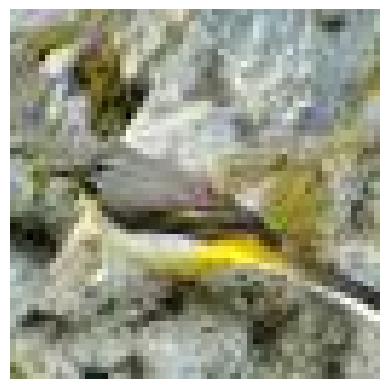

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# 첫 번째 이미지를 가져와서 출력
image_path = test_data[3]  # 첫 번째 이미지 경로
image = Image.open(image_path).convert("RGB")

# 변환 적용 없이 원본 이미지 출력
plt.imshow(image)
plt.axis('off')  # 축 제거
plt.show()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data  # 데이터 (이미지 경로)
        self.transform = transform  # 변환 (예: 데이터 증강)

    def __len__(self):
        return len(self.data)  # 데이터셋의 크기

    def __getitem__(self, idx):
        image_path = self.data[idx]  # 이미지 경로만 받음

        # 이미지 열기
        image = Image.open(image_path).convert("RGB")

        # transform이 정의되었으면 적용
        if self.transform:
            image = self.transform(image)

        return image  # 라벨을 반환하지 않음

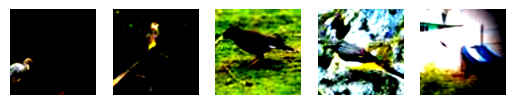

In [ ]:
# 테스트 데이터 경로만 포함된 리스트
test_dir = '/content/test'  # 경로를 실제 데이터에 맞게 수정해야 합니다.
test_data = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg') or fname.endswith('.png')]

# CustomDataset 정의
test_dataset = CustomDataset(test_data, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 첫 번째 배치 가져오기
images = next(iter(test_loader))  # 라벨이 없으므로 두 번째 인자 제외

# 이미지 변환 후 출력
for i in range(5):  # 첫 5개 이미지 출력
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].permute(1, 2, 0))  # (C, H, W) -> (H, W, C)로 변환
    plt.axis('off')
plt.show()


In [ ]:
# 첫 번째 이미지를 열어서 크기 확인
image = Image.open(image_path)
print(f"이미지 크기: {image.size} (Width, Height)")  # (Width, Height) 출력

이미지 크기: (64, 64) (Width, Height)


In [ ]:
# 고해상도 이미지를 변환한 후 크기 확인
transformed_image = val_transform(image)  # 변환을 적용
print(f"변환 후 이미지 크기: {transformed_image.size()}")  # 텐서 크기 확인 (채널, 높이, 너비)

변환 후 이미지 크기: torch.Size([3, 224, 224])


In [ ]:
# 이미 작성된 inference() 함수와 모델을 사용하여 테스트 데이터에 대해 예측
def inference(model, test_loader, device):
    model.eval()  # 평가 모드로 전환
    preds = []
    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs in tqdm(iter(test_loader)):  # 라벨은 사용하지 않음
            imgs = imgs.float().to(device)  # 이미지를 실수형으로 변환하고 GPU로 전송
            pred = model(imgs)  # 예측 수행
            preds += pred.argmax(1).detach().cpu().numpy().tolist()  # 예측 결과를 리스트에 저장

    preds = le.inverse_transform(preds)  # 라벨을 다시 원래대로 변환
    return preds

In [ ]:
# CustomDataset 수정: 라벨이 없는 테스트 데이터셋에서 이미지만 반환
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data  # 데이터 (이미지 파일 경로)
        self.transform = transform  # 변환 (예: 데이터 증강)

    def __len__(self):
        return len(self.data)  # 데이터셋의 크기

    def __getitem__(self, idx):
        image_path = self.data[idx]  # 이미지 경로

        # 이미지 열기
        image = Image.open(image_path).convert("RGB")

        # transform이 정의되었으면 적용
        if self.transform:
            image = self.transform(image)

        return image  # 라벨을 반환하지 않음

# 테스트 데이터셋 로딩
test_dataset = CustomDataset(test_data, transform=val_transform)  # CustomDataset은 transform 인자를 받습니다.

# DataLoader 정의
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # 배치 크기와 셔플 설정


  0%|          | 0/213 [00:01<?, ?it/s]


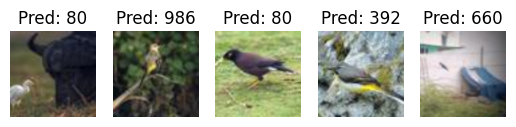

In [ ]:
# 예측 시각화 수정
def visualize_predictions(model, test_loader, device, num_images=5):
    model.eval()  # 평가 모드로 전환
    # Move the model to the correct device before inference
    model.to(device)  # Add this line to move the model to the GPU
    images_shown = 0

    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs in tqdm(iter(test_loader)):  # 라벨은 사용하지 않음
            imgs = imgs.float().to(device)  # 이미지를 실수형으로 변환하고 GPU로 전송
            preds = model(imgs)  # 예측 수행
            preds = preds.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            for i in range(len(imgs)):
                if images_shown >= num_images:  # 표시할 이미지 개수 제한
                    break

                img = imgs[i].cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
                img = (img - img.min()) / (img.max() - img.min())  # 정규화 (0, 1) 범위로 맞추기

                label = preds[i]  # 예측된 라벨
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {label}")
                plt.axis('off')
                images_shown += 1

            if images_shown >= num_images:
                break

    plt.show()

# 모델 예측 시각화
# 'infer_model'을 'model'로 변경
visualize_predictions(model, test_loader, device, num_images=5)

In [ ]:
# 예시: val_transform에서 크기 조정 확인
from torchvision import transforms
from PIL import Image

# 이미지 변환 정의 (고해상도 이미지를 resize 후 텐서로 변환)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 고해상도를 낮추는 크기 조정
    transforms.ToTensor(),  # 텐서 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 첫 번째 이미지를 변환하여 크기 확인
image = Image.open('/content/test/TEST_00003.jpg')  # 이미지 경로
transformed_image = val_transform(image)
print(f"변환 후 이미지 크기: {transformed_image.size()}")  # 텐서 크기 출력

변환 후 이미지 크기: torch.Size([3, 224, 224])


In [ ]:
# CustomDataset 수정: 라벨을 포함하여 반환
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data  # 이미지 파일 경로
        self.labels = labels  # 각 이미지의 라벨
        self.transform = transform  # 변환 (예: 데이터 증강)

    def __len__(self):
        return len(self.data)  # 데이터셋의 크기

    def __getitem__(self, idx):
        image_path = self.data[idx]  # 이미지 경로
        label = self.labels[idx]  # 해당 이미지의 라벨

        # 이미지 열기
        image = Image.open(image_path).convert("RGB")

        # transform이 정의되었으면 적용
        if self.transform:
            image = self.transform(image)

        return image, label  # 이미지와 라벨 반환


In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data  # 이미지 파일 경로
        self.labels = labels  # 각 이미지의 라벨
        self.transform = transform  # 변환 (예: 데이터 증강)

    def __len__(self):
        return len(self.data)  # 데이터셋의 크기

    def __getitem__(self, idx):
        image_path = self.data[idx]  # 이미지 경로
        label = self.labels[idx]  # 해당 이미지의 라벨

        # 이미지 열기
        image = Image.open(image_path).convert("RGB")

        # transform이 정의되었으면 적용
        if self.transform:
            image = self.transform(image)

        return image, label  # 이미지와 라벨 반환


In [ ]:
for data in tqdm(iter(test_loader)):
    print(type(data))  # 'data'의 타입을 확인
    print(len(data))   # 'data'의 길이를 확인
    print(data[0].shape)  # 이미지의 형태 확인
    print(data[1])  # 라벨 확인

  1%|          | 2/213 [00:00<00:14, 14.14it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.4843, -1.4843, -1.2959,  ..., -1.4158, -1.3987, -1.3987],
         [-1.4843, -1.4843, -1.2959,  ..., -1.4158, -1.3987, -1.3987],
         [-1.4158, -1.4158, -1.2274,  ..., -1.4158, -1.3987, -1.3987],
         ...,
         [-1.6555, -1.6555, -1.6727,  ..., -1.2788, -1.2788, -1.2788],
         [-1.7069, -1.7069, -1.7240,  ..., -1.2959, -1.2959, -1.2959],
         [-1.7069, -1.7069, -1.7240,  ..., -1.2959, -1.2959, -1.2959]],

        [[-1.6506, -1.6506, -1.4580,  ..., -1.3354, -1.3179, -1.3179],
         [-1.6506, -1.6506, -1.4580,  ..., -1.3354, -1.3179, -1.3179],
         [-1.5805, -1.5805, -1.3880,  ..., -1.3354, -1.3179, -1.3179],
         ...,
         [-1.4405, -1.4405, -1.4580,  ..., -1.3354, -1.3354, -1.3354],
         [-1.4755, -1.4755, -1.4930,  ..., -1.3529, -1.3529, -1.3529],
         [-1.4755, -1.4755, -1.4930,  ..., -1.3529, -1.3529, -1.3529]],

        [[-1.8044, -1.8044, -1.6824,  ..., -1.5953, -1.5779, -1.

  3%|▎         | 6/213 [00:00<00:13, 15.58it/s]

tensor([[[-1.0733, -1.0733, -1.0733,  ..., -0.5767, -0.5767, -0.5767],
         [-1.0733, -1.0733, -1.0733,  ..., -0.5767, -0.5767, -0.5767],
         [-1.0733, -1.0733, -1.0733,  ..., -0.5767, -0.5767, -0.5767],
         ...,
         [ 1.6495,  1.6495,  1.6495,  ...,  1.2557,  1.2728,  1.2728],
         [ 1.7009,  1.7009,  1.7009,  ...,  1.2385,  1.2557,  1.2557],
         [ 1.7009,  1.7009,  1.7009,  ...,  1.2385,  1.2557,  1.2557]],

        [[-0.7577, -0.7577, -0.7577,  ..., -0.2675, -0.2675, -0.2675],
         [-0.7577, -0.7577, -0.7577,  ..., -0.2675, -0.2675, -0.2675],
         [-0.7577, -0.7577, -0.7577,  ..., -0.2675, -0.2675, -0.2675],
         ...,
         [ 0.7829,  0.7829,  0.7829,  ...,  1.0280,  1.0455,  1.0455],
         [ 0.8179,  0.8179,  0.8179,  ...,  1.0105,  1.0280,  1.0280],
         [ 0.8179,  0.8179,  0.8179,  ...,  1.0105,  1.0280,  1.0280]],

        [[-0.9504, -0.9504, -0.9504,  ..., -0.5670, -0.5670, -0.5670],
         [-0.9504, -0.9504, -0.9504,  ..., -0

  5%|▍         | 10/213 [00:00<00:12, 16.04it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.9192, -0.9192, -0.8678,  ..., -0.2513, -0.2342, -0.2342],
         [-0.9192, -0.9192, -0.8678,  ..., -0.2513, -0.2342, -0.2342],
         [-0.9020, -0.9020, -0.8507,  ..., -0.2856, -0.2684, -0.2684],
         ...,
         [-0.5253, -0.5253, -0.6281,  ..., -1.2274, -1.2274, -1.2274],
         [-0.5424, -0.5424, -0.6452,  ..., -1.2959, -1.3130, -1.3130],
         [-0.5424, -0.5424, -0.6452,  ..., -1.2959, -1.3130, -1.3130]],

        [[-0.5126, -0.5126, -0.4601,  ..., -0.0224, -0.0049, -0.0049],
         [-0.5126, -0.5126, -0.4601,  ..., -0.0224, -0.0049, -0.0049],
         [-0.4951, -0.4951, -0.4426,  ..., -0.0574, -0.0399, -0.0399],
         ...,
         [-0.2325, -0.2325, -0.3200,  ..., -0.6877, -0.6877, -0.6877],
         [-0.2500, -0.2500, -0.3375,  ..., -0.7577, -0.7752, -0.7752],
         [-0.2500, -0.2500, -0.3375,  ..., -0.7577, -0.7752, -0.7752]],

        [[-1.2467, -1.2467, -1.1944,  ..., -1.0550, -1.0376, -1.

  7%|▋         | 14/213 [00:00<00:12, 16.15it/s]

tensor([[[ 0.7591,  0.7591,  0.7591,  ...,  0.1597,  0.2282,  0.2282],
         [ 0.7591,  0.7591,  0.7591,  ...,  0.1597,  0.2282,  0.2282],
         [ 0.7419,  0.7419,  0.7419,  ..., -0.0458,  0.0227,  0.0227],
         ...,
         [-1.2103, -1.2103, -1.1760,  ...,  0.8276,  0.8789,  0.8789],
         [-1.3130, -1.3130, -1.2959,  ...,  0.8447,  0.8961,  0.8961],
         [-1.3130, -1.3130, -1.2959,  ...,  0.8447,  0.8961,  0.8961]],

        [[ 0.7654,  0.7654,  0.7654,  ...,  0.1702,  0.2577,  0.2577],
         [ 0.7654,  0.7654,  0.7654,  ...,  0.1702,  0.2577,  0.2577],
         [ 0.7479,  0.7479,  0.7479,  ..., -0.0224,  0.0476,  0.0476],
         ...,
         [-1.2129, -1.2129, -1.1779,  ...,  0.8354,  0.8880,  0.8880],
         [-1.3179, -1.3179, -1.3004,  ...,  0.8529,  0.9055,  0.9055],
         [-1.3179, -1.3179, -1.3004,  ...,  0.8529,  0.9055,  0.9055]],

        [[ 0.9319,  0.9319,  0.9319,  ..., -0.2010, -0.1487, -0.1487],
         [ 0.9319,  0.9319,  0.9319,  ..., -0

  8%|▊         | 16/213 [00:01<00:12, 15.83it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[1.0673, 1.0673, 1.0673,  ..., 1.2728, 1.2728, 1.2728],
         [1.0673, 1.0673, 1.0673,  ..., 1.2728, 1.2728, 1.2728],
         [1.0159, 1.0159, 1.0159,  ..., 1.2728, 1.2728, 1.2728],
         ...,
         [1.1358, 1.1358, 1.1358,  ..., 1.3242, 1.3242, 1.3242],
         [1.1187, 1.1187, 1.1187,  ..., 1.3242, 1.3242, 1.3242],
         [1.1187, 1.1187, 1.1187,  ..., 1.3242, 1.3242, 1.3242]],

        [[1.2206, 1.2206, 1.2206,  ..., 1.4307, 1.4307, 1.4307],
         [1.2206, 1.2206, 1.2206,  ..., 1.4307, 1.4307, 1.4307],
         [1.1681, 1.1681, 1.1681,  ..., 1.4307, 1.4307, 1.4307],
         ...,
         [1.3081, 1.3081, 1.3081,  ..., 1.4657, 1.4657, 1.4657],
         [1.2906, 1.2906, 1.2906,  ..., 1.4657, 1.4657, 1.4657],
         [1.2906, 1.2906, 1.2906,  ..., 1.4657, 1.4657, 1.4657]],

        [[1.4025, 1.4025, 1.4025,  ..., 1.6465, 1.6465, 1.6465],
         [1.4025, 1.4025, 1.4025,  ..., 1.6465, 1.6465, 1.6465],
      

  9%|▉         | 20/213 [00:01<00:12, 15.35it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.1589, -1.1589, -1.1589,  ..., -0.8678, -0.8507, -0.8507],
         [-1.1589, -1.1589, -1.1589,  ..., -0.8678, -0.8507, -0.8507],
         [-1.1760, -1.1760, -1.1760,  ..., -0.8678, -0.8678, -0.8678],
         ...,
         [-1.5185, -1.5185, -1.4500,  ..., -0.5596, -0.5424, -0.5424],
         [-1.5870, -1.5870, -1.5185,  ..., -0.5424, -0.5253, -0.5253],
         [-1.5870, -1.5870, -1.5185,  ..., -0.5424, -0.5253, -0.5253]],

        [[-1.1954, -1.1954, -1.1954,  ..., -0.8277, -0.8102, -0.8102],
         [-1.1954, -1.1954, -1.1954,  ..., -0.8277, -0.8102, -0.8102],
         [-1.2129, -1.2129, -1.2129,  ..., -0.8277, -0.8277, -0.8277],
         ...,
         [-1.4755, -1.4755, -1.4055,  ..., -0.5651, -0.5476, -0.5476],
         [-1.5455, -1.5455, -1.4755,  ..., -0.5476, -0.5301, -0.5301],
         [-1.5455, -1.5455, -1.4755,  ..., -0.5476, -0.5301, -0.5301]],

        [[-1.0201, -1.0201, -1.0201,  ..., -1.0376, -1.0201, -1.

 11%|█▏        | 24/213 [00:01<00:12, 15.72it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[2.1975, 2.1975, 2.1975,  ..., 2.1119, 2.1119, 2.1119],
         [2.1975, 2.1975, 2.1975,  ..., 2.1119, 2.1119, 2.1119],
         [1.7694, 1.7694, 1.7865,  ..., 1.7523, 1.7523, 1.7523],
         ...,
         [1.8037, 1.8037, 1.7352,  ..., 1.7009, 1.7180, 1.7180],
         [2.0092, 2.0092, 1.9578,  ..., 2.1119, 2.1290, 2.1290],
         [2.0092, 2.0092, 1.9578,  ..., 2.1119, 2.1290, 2.1290]],

        [[2.3936, 2.3936, 2.3936,  ..., 2.4286, 2.4286, 2.4286],
         [2.3936, 2.3936, 2.3936,  ..., 2.4286, 2.4286, 2.4286],
         [1.9559, 1.9559, 1.9734,  ..., 2.0959, 2.0959, 2.0959],
         ...,
         [2.2535, 2.2535, 2.2010,  ..., 1.9734, 1.9909, 1.9909],
         [2.4286, 2.4286, 2.4111,  ..., 2.3936, 2.4111, 2.4111],
         [2.4286, 2.4286, 2.4111,  ..., 2.3936, 2.4111, 2.4111]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
      

 13%|█▎        | 28/213 [00:01<00:11, 16.38it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.9192, -0.9192, -0.8678,  ...,  0.0569,  0.0569,  0.0569],
         [-0.9192, -0.9192, -0.8678,  ...,  0.0569,  0.0569,  0.0569],
         [-0.8164, -0.8164, -0.7650,  ...,  0.0569,  0.0569,  0.0569],
         ...,
         [-0.3712, -0.3712, -0.4054,  ..., -1.2445, -1.2445, -1.2445],
         [-0.4226, -0.4226, -0.4568,  ..., -1.2445, -1.2617, -1.2617],
         [-0.4226, -0.4226, -0.4568,  ..., -1.2445, -1.2617, -1.2617]],

        [[-0.1099, -0.1099, -0.0574,  ...,  0.1702,  0.1702,  0.1702],
         [-0.1099, -0.1099, -0.0574,  ...,  0.1702,  0.1702,  0.1702],
         [-0.0049, -0.0049,  0.0476,  ...,  0.1877,  0.1702,  0.1702],
         ...,
         [-0.3901, -0.3901, -0.4251,  ..., -1.2304, -1.2304, -1.2304],
         [-0.4426, -0.4426, -0.4776,  ..., -1.2304, -1.2479, -1.2479],
         [-0.4426, -0.4426, -0.4776,  ..., -1.2304, -1.2479, -1.2479]],

        [[-0.9853, -0.9853, -0.9330,  ..., -0.4450, -0.4450, -0.

 15%|█▌        | 32/213 [00:02<00:10, 16.75it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.5767, -0.5767, -0.6109,  ...,  0.0056, -0.0972, -0.0972],
         [-0.5767, -0.5767, -0.6109,  ...,  0.0056, -0.0972, -0.0972],
         [-0.5938, -0.5938, -0.6109,  ...,  0.0056, -0.0801, -0.0801],
         ...,
         [ 0.9988,  0.9988,  1.0159,  ...,  1.1187,  1.0502,  1.0502],
         [ 1.0159,  1.0159,  1.0331,  ...,  1.1529,  1.0844,  1.0844],
         [ 1.0159,  1.0159,  1.0331,  ...,  1.1529,  1.0844,  1.0844]],

        [[-0.4776, -0.4776, -0.5126,  ...,  0.3277,  0.2227,  0.2227],
         [-0.4776, -0.4776, -0.5126,  ...,  0.3277,  0.2227,  0.2227],
         [-0.4951, -0.4951, -0.5126,  ...,  0.3277,  0.2402,  0.2402],
         ...,
         [ 0.7304,  0.7304,  0.7654,  ...,  0.5203,  0.4503,  0.4503],
         [ 0.7479,  0.7479,  0.7829,  ...,  0.5378,  0.4678,  0.4678],
         [ 0.7479,  0.7479,  0.7829,  ...,  0.5378,  0.4678,  0.4678]],

        [[-1.0201, -1.0201, -1.0550,  ..., -0.6193, -0.7413, -0.

 17%|█▋        | 36/213 [00:02<00:10, 16.48it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.7933,  0.7933,  0.7762,  ...,  0.6221,  0.5878,  0.5878],
         [ 0.7933,  0.7933,  0.7762,  ...,  0.6221,  0.5878,  0.5878],
         [ 0.7591,  0.7591,  0.7419,  ...,  0.5878,  0.5364,  0.5364],
         ...,
         [ 0.1597,  0.1597,  0.2282,  ..., -0.4054, -0.5424, -0.5424],
         [ 0.1426,  0.1426,  0.2111,  ..., -0.4054, -0.5424, -0.5424],
         [ 0.1426,  0.1426,  0.2111,  ..., -0.4054, -0.5424, -0.5424]],

        [[ 1.1681,  1.1681,  1.1506,  ...,  0.9580,  0.9405,  0.9405],
         [ 1.1681,  1.1681,  1.1506,  ...,  0.9580,  0.9405,  0.9405],
         [ 1.1331,  1.1331,  1.1155,  ...,  0.9230,  0.8880,  0.8880],
         ...,
         [ 0.4853,  0.4853,  0.5553,  ..., -0.2150, -0.3550, -0.3550],
         [ 0.4678,  0.4678,  0.5378,  ..., -0.2150, -0.3550, -0.3550],
         [ 0.4678,  0.4678,  0.5378,  ..., -0.2150, -0.3550, -0.3550]],

        [[ 0.4439,  0.4439,  0.4265,  ...,  0.1128,  0.0779,  0.

 19%|█▉        | 40/213 [00:02<00:11, 15.46it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.3541, -0.3541, -0.2856,  ...,  0.4851,  0.6734,  0.6734],
         [-0.3541, -0.3541, -0.2856,  ...,  0.4851,  0.6734,  0.6734],
         [-0.3027, -0.3027, -0.2513,  ...,  0.4679,  0.6392,  0.6392],
         ...,
         [-1.2788, -1.2788, -1.2788,  ..., -0.3198, -0.3883, -0.3883],
         [-1.2788, -1.2788, -1.2788,  ..., -0.2342, -0.2856, -0.2856],
         [-1.2788, -1.2788, -1.2788,  ..., -0.2342, -0.2856, -0.2856]],

        [[ 0.0826,  0.0826,  0.1527,  ..., -0.0924,  0.0826,  0.0826],
         [ 0.0826,  0.0826,  0.1527,  ..., -0.0924,  0.0826,  0.0826],
         [ 0.1352,  0.1352,  0.1877,  ..., -0.1099,  0.0651,  0.0651],
         ...,
         [-0.7927, -0.7927, -0.7927,  ...,  0.1352,  0.0476,  0.0476],
         [-0.7927, -0.7927, -0.7927,  ...,  0.2227,  0.1702,  0.1702],
         [-0.7927, -0.7927, -0.7927,  ...,  0.2227,  0.1702,  0.1702]],

        [[-0.4275, -0.4275, -0.3753,  ...,  0.1825,  0.3742,  0.

 21%|██        | 44/213 [00:02<00:10, 16.29it/s]

tensor([[[0.6734, 0.6734, 0.6734,  ..., 0.6392, 0.6392, 0.6392],
         [0.6734, 0.6734, 0.6734,  ..., 0.6392, 0.6392, 0.6392],
         [0.6734, 0.6734, 0.6734,  ..., 0.6392, 0.6392, 0.6392],
         ...,
         [0.5878, 0.5878, 0.5878,  ..., 0.4679, 0.4679, 0.4679],
         [0.5878, 0.5878, 0.5878,  ..., 0.4679, 0.4679, 0.4679],
         [0.5878, 0.5878, 0.5878,  ..., 0.4679, 0.4679, 0.4679]],

        [[1.0280, 1.0280, 1.0280,  ..., 0.9930, 0.9930, 0.9930],
         [1.0280, 1.0280, 1.0280,  ..., 0.9930, 0.9930, 0.9930],
         [1.0280, 1.0280, 1.0280,  ..., 0.9930, 0.9930, 0.9930],
         ...,
         [0.8529, 0.8529, 0.8529,  ..., 0.8354, 0.8354, 0.8354],
         [0.8529, 0.8529, 0.8529,  ..., 0.8354, 0.8354, 0.8354],
         [0.8529, 0.8529, 0.8529,  ..., 0.8354, 0.8354, 0.8354]],

        [[1.4897, 1.4897, 1.4897,  ..., 1.4548, 1.4548, 1.4548],
         [1.4897, 1.4897, 1.4897,  ..., 1.4548, 1.4548, 1.4548],
         [1.4897, 1.4897, 1.4897,  ..., 1.4548, 1.4548, 1.

 23%|██▎       | 48/213 [00:03<00:10, 15.83it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.1657, -0.1657, -0.1143,  ...,  0.7762,  0.7933,  0.7933],
         [-0.1657, -0.1657, -0.1143,  ...,  0.7762,  0.7933,  0.7933],
         [-0.2684, -0.2684, -0.2342,  ...,  0.7419,  0.7762,  0.7762],
         ...,
         [-0.0801, -0.0801,  0.0056,  ...,  0.0227,  0.1426,  0.1426],
         [-0.1314, -0.1314, -0.0116,  ..., -0.0116,  0.1254,  0.1254],
         [-0.1314, -0.1314, -0.0116,  ..., -0.0116,  0.1254,  0.1254]],

        [[-0.2850, -0.2850, -0.2325,  ...,  0.6604,  0.6779,  0.6779],
         [-0.2850, -0.2850, -0.2325,  ...,  0.6604,  0.6779,  0.6779],
         [-0.3901, -0.3901, -0.3550,  ...,  0.6254,  0.6604,  0.6604],
         ...,
         [-0.2150, -0.2150, -0.1275,  ..., -0.0399,  0.0826,  0.0826],
         [-0.2675, -0.2675, -0.1450,  ..., -0.0749,  0.0651,  0.0651],
         [-0.2675, -0.2675, -0.1450,  ..., -0.0749,  0.0651,  0.0651]],

        [[-0.6715, -0.6715, -0.6193,  ...,  0.3393,  0.3568,  0.

 24%|██▍       | 52/213 [00:03<00:10, 15.78it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.0801, -0.0801, -0.0629,  ..., -0.1828, -0.1486, -0.1486],
         [-0.0801, -0.0801, -0.0629,  ..., -0.1828, -0.1486, -0.1486],
         [-0.0801, -0.0801, -0.0629,  ..., -0.2171, -0.1828, -0.1828],
         ...,
         [ 0.2624,  0.2624,  0.2796,  ..., -0.3198, -0.3541, -0.3541],
         [ 0.2624,  0.2624,  0.2796,  ..., -0.3712, -0.4226, -0.4226],
         [ 0.2624,  0.2624,  0.2796,  ..., -0.3712, -0.4226, -0.4226]],

        [[ 0.1702,  0.1702,  0.1877,  ..., -0.1800, -0.1450, -0.1450],
         [ 0.1702,  0.1702,  0.1877,  ..., -0.1800, -0.1450, -0.1450],
         [ 0.1702,  0.1702,  0.1877,  ..., -0.2150, -0.1800, -0.1800],
         ...,
         [ 0.3978,  0.3978,  0.4153,  ..., -0.1625, -0.1975, -0.1975],
         [ 0.3978,  0.3978,  0.4153,  ..., -0.2150, -0.2675, -0.2675],
         [ 0.3978,  0.3978,  0.4153,  ..., -0.2150, -0.2675, -0.2675]],

        [[-0.4973, -0.4973, -0.4798,  ..., -0.4624, -0.4275, -0.

 26%|██▋       | 56/213 [00:03<00:09, 16.22it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.5364,  0.5364,  0.5364,  ...,  0.5536,  0.5193,  0.5193],
         [ 0.5364,  0.5364,  0.5364,  ...,  0.5536,  0.5193,  0.5193],
         [ 0.5536,  0.5536,  0.5536,  ...,  0.5536,  0.5193,  0.5193],
         ...,
         [ 0.0741,  0.0741,  0.0569,  ..., -0.1828, -0.1657, -0.1657],
         [ 0.0569,  0.0569,  0.0398,  ..., -0.1143, -0.0972, -0.0972],
         [ 0.0569,  0.0569,  0.0398,  ..., -0.1143, -0.0972, -0.0972]],

        [[ 0.3803,  0.3803,  0.3803,  ...,  0.4853,  0.4503,  0.4503],
         [ 0.3803,  0.3803,  0.3803,  ...,  0.4853,  0.4503,  0.4503],
         [ 0.3978,  0.3978,  0.3978,  ...,  0.4853,  0.4503,  0.4503],
         ...,
         [ 0.0651,  0.0651,  0.0476,  ..., -0.1275, -0.1099, -0.1099],
         [ 0.0476,  0.0476,  0.0301,  ..., -0.0749, -0.0574, -0.0574],
         [ 0.0476,  0.0476,  0.0301,  ..., -0.0749, -0.0574, -0.0574]],

        [[-0.1487, -0.1487, -0.1487,  ...,  0.3219,  0.2871,  0.

 28%|██▊       | 60/213 [00:03<00:09, 16.11it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.7591,  0.7591,  0.7077,  ..., -0.0801, -0.1828, -0.1828],
         [ 0.7591,  0.7591,  0.7077,  ..., -0.0801, -0.1828, -0.1828],
         [ 0.6906,  0.6906,  0.6392,  ..., -0.0287, -0.1314, -0.1314],
         ...,
         [ 0.1597,  0.1597,  0.1768,  ...,  0.2282,  0.1939,  0.1939],
         [ 0.1426,  0.1426,  0.1426,  ...,  0.1939,  0.1597,  0.1597],
         [ 0.1426,  0.1426,  0.1426,  ...,  0.1939,  0.1597,  0.1597]],

        [[ 0.8004,  0.8004,  0.7479,  ..., -0.0399, -0.1450, -0.1450],
         [ 0.8004,  0.8004,  0.7479,  ..., -0.0399, -0.1450, -0.1450],
         [ 0.7304,  0.7304,  0.6779,  ...,  0.0126, -0.0924, -0.0924],
         ...,
         [ 0.2577,  0.2577,  0.2752,  ...,  0.1352,  0.1001,  0.1001],
         [ 0.2402,  0.2402,  0.2402,  ...,  0.1001,  0.0651,  0.0651],
         [ 0.2402,  0.2402,  0.2402,  ...,  0.1001,  0.0651,  0.0651]],

        [[-0.3055, -0.3055, -0.3578,  ..., -0.9330, -1.0376, -1.

 30%|███       | 64/213 [00:04<00:08, 16.59it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.5424, -0.5424, -0.5424,  ..., -0.0287, -0.0287, -0.0287],
         [-0.5424, -0.5424, -0.5424,  ..., -0.0287, -0.0287, -0.0287],
         [-0.5424, -0.5424, -0.5424,  ..., -0.0116, -0.0116, -0.0116],
         ...,
         [ 0.7591,  0.7591,  0.6734,  ...,  0.5707,  0.5707,  0.5707],
         [ 0.7762,  0.7762,  0.7077,  ...,  0.5536,  0.5536,  0.5536],
         [ 0.7762,  0.7762,  0.7077,  ...,  0.5536,  0.5536,  0.5536]],

        [[-0.3725, -0.3725, -0.3725,  ..., -0.0224, -0.0224, -0.0224],
         [-0.3725, -0.3725, -0.3725,  ..., -0.0224, -0.0224, -0.0224],
         [-0.3725, -0.3725, -0.3725,  ..., -0.0049, -0.0049, -0.0049],
         ...,
         [ 0.7304,  0.7304,  0.6429,  ...,  0.4678,  0.4678,  0.4678],
         [ 0.7479,  0.7479,  0.6779,  ...,  0.4328,  0.4328,  0.4328],
         [ 0.7479,  0.7479,  0.6779,  ...,  0.4328,  0.4328,  0.4328]],

        [[-0.0615, -0.0615, -0.0615,  ...,  0.0953,  0.0953,  0.

 32%|███▏      | 68/213 [00:04<00:08, 16.71it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.5596, -0.5596, -0.5596,  ...,  0.8961,  0.9132,  0.9132],
         [-0.5596, -0.5596, -0.5596,  ...,  0.8961,  0.9132,  0.9132],
         [-0.4739, -0.4739, -0.4739,  ...,  0.8961,  0.9132,  0.9132],
         ...,
         [ 0.1597,  0.1597,  0.1254,  ...,  0.2967,  0.2453,  0.2453],
         [ 0.1254,  0.1254,  0.0912,  ...,  0.3138,  0.2624,  0.2624],
         [ 0.1254,  0.1254,  0.0912,  ...,  0.3138,  0.2624,  0.2624]],

        [[-0.9503, -0.9503, -0.9503,  ...,  0.5553,  0.5728,  0.5728],
         [-0.9503, -0.9503, -0.9503,  ...,  0.5553,  0.5728,  0.5728],
         [-0.8627, -0.8627, -0.8627,  ...,  0.5553,  0.5728,  0.5728],
         ...,
         [-0.1800, -0.1800, -0.2150,  ...,  0.0651,  0.0126,  0.0126],
         [-0.2150, -0.2150, -0.2500,  ...,  0.0826,  0.0301,  0.0301],
         [-0.2150, -0.2150, -0.2500,  ...,  0.0826,  0.0301,  0.0301]],

        [[-1.3164, -1.3164, -1.3164,  ...,  0.1302,  0.1476,  0.

 34%|███▍      | 72/213 [00:04<00:08, 16.92it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.2856, -0.2856, -0.3027,  ..., -1.6042, -1.5699, -1.5699],
         [-0.2856, -0.2856, -0.3027,  ..., -1.6042, -1.5699, -1.5699],
         [-0.2856, -0.2856, -0.3027,  ..., -1.5699, -1.5357, -1.5357],
         ...,
         [ 0.0741,  0.0741,  0.0569,  ..., -0.3027, -0.2171, -0.2171],
         [ 0.0741,  0.0741,  0.0569,  ..., -0.2684, -0.1828, -0.1828],
         [ 0.0741,  0.0741,  0.0569,  ..., -0.2684, -0.1828, -0.1828]],

        [[-0.4601, -0.4601, -0.4601,  ..., -1.4755, -1.4405, -1.4405],
         [-0.4601, -0.4601, -0.4601,  ..., -1.4755, -1.4405, -1.4405],
         [-0.4601, -0.4601, -0.4601,  ..., -1.4405, -1.4055, -1.4055],
         ...,
         [-0.0749, -0.0749, -0.0924,  ...,  0.2227,  0.3102,  0.3102],
         [-0.0749, -0.0749, -0.0924,  ...,  0.2577,  0.3452,  0.3452],
         [-0.0749, -0.0749, -0.0924,  ...,  0.2577,  0.3452,  0.3452]],

        [[-0.9853, -0.9853, -0.9853,  ..., -1.4907, -1.4559, -1.

 36%|███▌      | 76/213 [00:04<00:08, 16.17it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.4337,  0.4337,  0.1939,  ...,  0.0741,  0.0569,  0.0569],
         [ 0.4337,  0.4337,  0.1939,  ...,  0.0741,  0.0569,  0.0569],
         [ 0.2967,  0.2967,  0.1254,  ...,  0.0741,  0.0569,  0.0569],
         ...,
         [-0.8164, -0.8164, -0.8335,  ..., -1.5014, -1.4672, -1.4672],
         [-0.7993, -0.7993, -0.8164,  ..., -1.5014, -1.4843, -1.4843],
         [-0.7993, -0.7993, -0.8164,  ..., -1.5014, -1.4843, -1.4843]],

        [[ 0.5028,  0.5028,  0.2752,  ..., -0.0049, -0.0224, -0.0224],
         [ 0.5028,  0.5028,  0.2752,  ..., -0.0049, -0.0224, -0.0224],
         [ 0.3627,  0.3627,  0.1877,  ..., -0.0049, -0.0224, -0.0224],
         ...,
         [-0.4951, -0.4951, -0.5126,  ..., -1.1253, -1.1078, -1.1078],
         [-0.4776, -0.4776, -0.4951,  ..., -1.1253, -1.1078, -1.1078],
         [-0.4776, -0.4776, -0.4951,  ..., -1.1253, -1.1078, -1.1078]],

        [[-0.3404, -0.3404, -0.5670,  ..., -0.4450, -0.4624, -0.

 38%|███▊      | 80/213 [00:05<00:08, 15.51it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.2513, -0.2513, -0.3369,  ...,  0.6221,  0.7419,  0.7419],
         [-0.2513, -0.2513, -0.3369,  ...,  0.6221,  0.7419,  0.7419],
         [-0.3712, -0.3712, -0.4568,  ...,  0.3994,  0.5193,  0.5193],
         ...,
         [-0.7993, -0.7993, -0.7650,  ..., -1.1760, -1.1418, -1.1418],
         [-0.7993, -0.7993, -0.7822,  ..., -1.1418, -1.1075, -1.1075],
         [-0.7993, -0.7993, -0.7822,  ..., -1.1418, -1.1075, -1.1075]],

        [[ 0.3102,  0.3102,  0.2227,  ...,  0.7829,  0.9055,  0.9055],
         [ 0.3102,  0.3102,  0.2227,  ...,  0.7829,  0.9055,  0.9055],
         [ 0.1877,  0.1877,  0.1001,  ...,  0.5553,  0.6779,  0.6779],
         ...,
         [-0.4951, -0.4951, -0.4776,  ..., -1.1429, -1.1078, -1.1078],
         [-0.4951, -0.4951, -0.4776,  ..., -1.1078, -1.0728, -1.0728],
         [-0.4951, -0.4951, -0.4776,  ..., -1.1078, -1.0728, -1.0728]],

        [[-0.6193, -0.6193, -0.7064,  ...,  1.1062,  1.2108,  1.

 39%|███▉      | 84/213 [00:05<00:08, 15.35it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.7308, -0.7308, -0.7308,  ..., -0.5767, -0.5253, -0.5253],
         [-0.7308, -0.7308, -0.7308,  ..., -0.5767, -0.5253, -0.5253],
         [-0.7308, -0.7308, -0.7308,  ..., -0.5424, -0.4911, -0.4911],
         ...,
         [-0.9020, -0.9020, -0.9020,  ..., -0.5767, -0.5767, -0.5767],
         [-0.9020, -0.9020, -0.9020,  ..., -0.5767, -0.5767, -0.5767],
         [-0.9020, -0.9020, -0.9020,  ..., -0.5767, -0.5767, -0.5767]],

        [[-0.6352, -0.6352, -0.6352,  ..., -0.2325, -0.1800, -0.1800],
         [-0.6352, -0.6352, -0.6352,  ..., -0.2325, -0.1800, -0.1800],
         [-0.6352, -0.6352, -0.6352,  ..., -0.2150, -0.1625, -0.1625],
         ...,
         [-0.8277, -0.8277, -0.8277,  ..., -0.2850, -0.2675, -0.2675],
         [-0.8277, -0.8277, -0.8277,  ..., -0.2850, -0.2675, -0.2675],
         [-0.8277, -0.8277, -0.8277,  ..., -0.2850, -0.2675, -0.2675]],

        [[-1.1770, -1.1770, -1.1770,  ..., -0.4624, -0.4101, -0.

 41%|████▏     | 88/213 [00:05<00:07, 15.78it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.2274, -1.2274, -1.2788,  ...,  0.2111,  0.2282,  0.2282],
         [-1.2274, -1.2274, -1.2788,  ...,  0.2111,  0.2282,  0.2282],
         [-1.2445, -1.2445, -1.2959,  ...,  0.1254,  0.1426,  0.1426],
         ...,
         [-0.5767, -0.5767, -0.7650,  ...,  0.0912,  0.0056,  0.0056],
         [-0.4739, -0.4739, -0.6623,  ...,  0.0912,  0.0056,  0.0056],
         [-0.4739, -0.4739, -0.6623,  ...,  0.0912,  0.0056,  0.0056]],

        [[-1.2304, -1.2304, -1.2829,  ...,  0.2052,  0.2227,  0.2227],
         [-1.2304, -1.2304, -1.2829,  ...,  0.2052,  0.2227,  0.2227],
         [-1.2479, -1.2479, -1.3004,  ...,  0.1176,  0.1352,  0.1352],
         ...,
         [-0.2675, -0.2675, -0.4601,  ...,  0.5028,  0.4153,  0.4153],
         [-0.1625, -0.1625, -0.3550,  ...,  0.5028,  0.4153,  0.4153],
         [-0.1625, -0.1625, -0.3550,  ...,  0.5028,  0.4153,  0.4153]],

        [[-0.7936, -0.7936, -0.8633,  ...,  0.0953,  0.1128,  0.

 43%|████▎     | 92/213 [00:05<00:07, 16.16it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.5185, -1.5185, -1.5185,  ...,  0.1597,  0.0056,  0.0056],
         [-1.5185, -1.5185, -1.5185,  ...,  0.1597,  0.0056,  0.0056],
         [-1.5185, -1.5185, -1.5185,  ...,  0.1597,  0.0227,  0.0227],
         ...,
         [-0.9363, -0.9363, -0.9705,  ..., -1.1418, -1.1760, -1.1760],
         [-0.8849, -0.8849, -0.9363,  ..., -1.0390, -1.0733, -1.0733],
         [-0.8849, -0.8849, -0.9363,  ..., -1.0390, -1.0733, -1.0733]],

        [[-0.4601, -0.4601, -0.4776,  ...,  1.4482,  1.3431,  1.3431],
         [-0.4601, -0.4601, -0.4776,  ...,  1.4482,  1.3431,  1.3431],
         [-0.4776, -0.4776, -0.4951,  ...,  1.4482,  1.3431,  1.3431],
         ...,
         [-0.1275, -0.1275, -0.1625,  ..., -1.2654, -1.3354, -1.3354],
         [-0.0749, -0.0749, -0.1099,  ..., -1.1604, -1.2304, -1.2304],
         [-0.0749, -0.0749, -0.1099,  ..., -1.1604, -1.2304, -1.2304]],

        [[-1.3687, -1.3687, -1.3687,  ...,  0.8971,  0.7751,  0.

 45%|████▌     | 96/213 [00:06<00:07, 16.56it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 1.1872,  1.1872,  1.1872,  ...,  1.4612,  1.4954,  1.4954],
         [ 1.1872,  1.1872,  1.1872,  ...,  1.4612,  1.4954,  1.4954],
         [ 1.1872,  1.1872,  1.1872,  ...,  1.4440,  1.4612,  1.4612],
         ...,
         [-0.6452, -0.6452, -0.5767,  ...,  1.1529,  1.1529,  1.1529],
         [-0.6281, -0.6281, -0.5253,  ...,  1.1187,  1.1015,  1.1015],
         [-0.6281, -0.6281, -0.5253,  ...,  1.1187,  1.1015,  1.1015]],

        [[ 1.4132,  1.4132,  1.4132,  ...,  1.6583,  1.6933,  1.6933],
         [ 1.4132,  1.4132,  1.4132,  ...,  1.6583,  1.6933,  1.6933],
         [ 1.4132,  1.4132,  1.4132,  ...,  1.6408,  1.6583,  1.6583],
         ...,
         [-0.8102, -0.8102, -0.7402,  ...,  1.2731,  1.2556,  1.2556],
         [-0.7927, -0.7927, -0.6877,  ...,  1.2381,  1.2031,  1.2031],
         [-0.7927, -0.7927, -0.6877,  ...,  1.2381,  1.2031,  1.2031]],

        [[ 0.7576,  0.7576,  0.7576,  ...,  2.1520,  2.1694,  2.

 47%|████▋     | 100/213 [00:06<00:06, 16.49it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[0.9132, 0.9132, 0.9132,  ..., 0.9474, 0.9474, 0.9474],
         [0.9132, 0.9132, 0.9132,  ..., 0.9474, 0.9474, 0.9474],
         [0.9132, 0.9132, 0.9132,  ..., 0.9474, 0.9474, 0.9474],
         ...,
         [0.8961, 0.8961, 0.8961,  ..., 0.7933, 0.7933, 0.7933],
         [0.8789, 0.8789, 0.8789,  ..., 0.7933, 0.7933, 0.7933],
         [0.8789, 0.8789, 0.8789,  ..., 0.7933, 0.7933, 0.7933]],

        [[1.8683, 1.8683, 1.8683,  ..., 1.8158, 1.8158, 1.8158],
         [1.8683, 1.8683, 1.8683,  ..., 1.8158, 1.8158, 1.8158],
         [1.8683, 1.8683, 1.8683,  ..., 1.8158, 1.8158, 1.8158],
         ...,
         [1.7633, 1.7633, 1.7633,  ..., 1.7108, 1.7108, 1.7108],
         [1.7458, 1.7458, 1.7458,  ..., 1.7108, 1.7108, 1.7108],
         [1.7458, 1.7458, 1.7458,  ..., 1.7108, 1.7108, 1.7108]],

        [[2.5006, 2.5006, 2.5006,  ..., 2.5180, 2.5180, 2.5180],
         [2.5006, 2.5006, 2.5006,  ..., 2.5180, 2.5180, 2.5180],
      

 49%|████▉     | 104/213 [00:06<00:06, 16.28it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.5022,  0.5022,  0.4508,  ...,  1.5810,  1.5639,  1.5639],
         [ 0.5022,  0.5022,  0.4508,  ...,  1.5810,  1.5639,  1.5639],
         [ 0.4851,  0.4851,  0.4337,  ...,  1.5639,  1.5468,  1.5468],
         ...,
         [ 1.1529,  1.1529,  1.2043,  ..., -0.0287, -0.0287, -0.0287],
         [ 0.9817,  0.9817,  1.0502,  ..., -0.0629, -0.0629, -0.0629],
         [ 0.9817,  0.9817,  1.0502,  ..., -0.0629, -0.0629, -0.0629]],

        [[ 0.6078,  0.6078,  0.5553,  ...,  1.4482,  1.4307,  1.4307],
         [ 0.6078,  0.6078,  0.5553,  ...,  1.4482,  1.4307,  1.4307],
         [ 0.5903,  0.5903,  0.5378,  ...,  1.4307,  1.4132,  1.4132],
         ...,
         [ 1.0455,  1.0455,  1.0980,  ...,  0.0826,  0.0826,  0.0826],
         [ 0.8704,  0.8704,  0.9405,  ...,  0.0476,  0.0476,  0.0476],
         [ 0.8704,  0.8704,  0.9405,  ...,  0.0476,  0.0476,  0.0476]],

        [[ 0.9145,  0.9145,  0.8622,  ...,  1.4897,  1.4722,  1.

 51%|█████     | 108/213 [00:06<00:06, 16.44it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.2274, -1.2274, -1.2274,  ...,  0.3309,  0.3652,  0.3652],
         [-1.2274, -1.2274, -1.2274,  ...,  0.3309,  0.3652,  0.3652],
         [-1.2274, -1.2274, -1.2274,  ...,  0.3138,  0.3481,  0.3481],
         ...,
         [-1.3473, -1.3473, -1.3302,  ...,  1.0159,  1.0331,  1.0331],
         [-1.3473, -1.3473, -1.3302,  ...,  1.0673,  1.0844,  1.0844],
         [-1.3473, -1.3473, -1.3302,  ...,  1.0673,  1.0844,  1.0844]],

        [[-0.7752, -0.7752, -0.7752,  ...,  0.9405,  0.9755,  0.9755],
         [-0.7752, -0.7752, -0.7752,  ...,  0.9405,  0.9755,  0.9755],
         [-0.7752, -0.7752, -0.7752,  ...,  0.9230,  0.9580,  0.9580],
         ...,
         [-0.8978, -0.8978, -0.8803,  ...,  0.9580,  0.9580,  0.9580],
         [-0.8978, -0.8978, -0.8803,  ...,  0.9930,  0.9930,  0.9930],
         [-0.8978, -0.8978, -0.8803,  ...,  0.9930,  0.9930,  0.9930]],

        [[-1.1944, -1.1944, -1.1944,  ...,  0.8971,  0.9319,  0.

 53%|█████▎    | 112/213 [00:06<00:05, 16.98it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.4739, -0.4739, -0.4568,  ..., -0.4226, -0.3883, -0.3883],
         [-0.4739, -0.4739, -0.4568,  ..., -0.4226, -0.3883, -0.3883],
         [-0.4739, -0.4739, -0.4568,  ..., -0.4397, -0.4054, -0.4054],
         ...,
         [ 1.0844,  1.0844,  1.1187,  ...,  0.0227, -0.0287, -0.0287],
         [ 1.3413,  1.3413,  1.3413,  ..., -0.0458, -0.1143, -0.1143],
         [ 1.3413,  1.3413,  1.3413,  ..., -0.0458, -0.1143, -0.1143]],

        [[-0.0924, -0.0924, -0.0574,  ..., -0.0574, -0.0224, -0.0224],
         [-0.0924, -0.0924, -0.0574,  ..., -0.0574, -0.0224, -0.0224],
         [-0.0749, -0.0749, -0.0399,  ..., -0.0749, -0.0399, -0.0399],
         ...,
         [ 1.3957,  1.3957,  1.4132,  ...,  0.4328,  0.3803,  0.3803],
         [ 1.6583,  1.6583,  1.6583,  ...,  0.3627,  0.2927,  0.2927],
         [ 1.6583,  1.6583,  1.6583,  ...,  0.3627,  0.2927,  0.2927]],

        [[-0.2358, -0.2358, -0.2010,  ..., -0.4275, -0.3753, -0.

 54%|█████▍    | 116/213 [00:07<00:06, 15.81it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.2617, -1.2617, -1.3130,  ..., -1.2103, -1.1760, -1.1760],
         [-1.2617, -1.2617, -1.3130,  ..., -1.2103, -1.1760, -1.1760],
         [-1.2274, -1.2274, -1.2788,  ..., -1.2959, -1.2617, -1.2617],
         ...,
         [ 0.1426,  0.1426,  0.1254,  ..., -0.4739, -0.4911, -0.4911],
         [ 0.1426,  0.1426,  0.1254,  ..., -0.4911, -0.5082, -0.5082],
         [ 0.1426,  0.1426,  0.1254,  ..., -0.4911, -0.5082, -0.5082]],

        [[-0.9503, -0.9503, -1.0028,  ..., -1.0553, -1.0203, -1.0203],
         [-0.9503, -0.9503, -1.0028,  ..., -1.0553, -1.0203, -1.0203],
         [-0.9153, -0.9153, -0.9678,  ..., -1.1429, -1.1078, -1.1078],
         ...,
         [ 0.4678,  0.4678,  0.4503,  ...,  0.1176,  0.1001,  0.1001],
         [ 0.4678,  0.4678,  0.4503,  ...,  0.1001,  0.0826,  0.0826],
         [ 0.4678,  0.4678,  0.4503,  ...,  0.1001,  0.0826,  0.0826]],

        [[-0.9678, -0.9678, -1.0376,  ..., -0.9853, -0.9504, -0.

 56%|█████▋    | 120/213 [00:07<00:05, 15.83it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.5185, -1.5185, -1.5185,  ..., -1.3815, -1.3815, -1.3815],
         [-1.5185, -1.5185, -1.5185,  ..., -1.3815, -1.3815, -1.3815],
         [-1.5014, -1.5014, -1.5014,  ..., -1.3815, -1.3815, -1.3815],
         ...,
         [ 0.2624,  0.2624,  0.2624,  ...,  0.4508,  0.4337,  0.4337],
         [ 0.2624,  0.2624,  0.2624,  ...,  0.4337,  0.4166,  0.4166],
         [ 0.2624,  0.2624,  0.2624,  ...,  0.4337,  0.4166,  0.4166]],

        [[-0.6702, -0.6702, -0.6702,  ..., -0.5301, -0.5301, -0.5301],
         [-0.6702, -0.6702, -0.6702,  ..., -0.5301, -0.5301, -0.5301],
         [-0.6702, -0.6702, -0.6702,  ..., -0.5301, -0.5301, -0.5301],
         ...,
         [ 0.6779,  0.6779,  0.6779,  ...,  0.6254,  0.6254,  0.6254],
         [ 0.6779,  0.6779,  0.6779,  ...,  0.6078,  0.6078,  0.6078],
         [ 0.6779,  0.6779,  0.6779,  ...,  0.6078,  0.6078,  0.6078]],

        [[-1.3861, -1.3861, -1.3861,  ..., -1.2293, -1.2293, -1.

 58%|█████▊    | 124/213 [00:07<00:05, 15.74it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.3309,  0.3309,  0.3309,  ..., -0.0629, -0.0629, -0.0629],
         [ 0.3309,  0.3309,  0.3309,  ..., -0.0629, -0.0629, -0.0629],
         [ 0.3481,  0.3481,  0.3481,  ..., -0.0458, -0.0458, -0.0458],
         ...,
         [ 0.3309,  0.3309,  0.3994,  ...,  1.7352,  1.6495,  1.6495],
         [ 0.3823,  0.3823,  0.4679,  ...,  1.8893,  1.8208,  1.8208],
         [ 0.3823,  0.3823,  0.4679,  ...,  1.8893,  1.8208,  1.8208]],

        [[ 0.4853,  0.4853,  0.4853,  ...,  0.0651,  0.0651,  0.0651],
         [ 0.4853,  0.4853,  0.4853,  ...,  0.0651,  0.0651,  0.0651],
         [ 0.5028,  0.5028,  0.5028,  ...,  0.0826,  0.0826,  0.0826],
         ...,
         [ 0.6254,  0.6254,  0.6954,  ...,  1.7983,  1.7283,  1.7283],
         [ 0.6779,  0.6779,  0.7654,  ...,  1.9559,  1.8859,  1.8859],
         [ 0.6779,  0.6779,  0.7654,  ...,  1.9559,  1.8859,  1.8859]],

        [[ 0.6008,  0.6008,  0.6008,  ...,  0.2522,  0.2522,  0.

 60%|██████    | 128/213 [00:07<00:05, 16.40it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.7933,  0.7933,  0.8618,  ...,  1.1015,  1.0844,  1.0844],
         [ 0.7933,  0.7933,  0.8618,  ...,  1.1015,  1.0844,  1.0844],
         [ 0.7419,  0.7419,  0.8104,  ...,  1.1015,  1.0844,  1.0844],
         ...,
         [-1.3302, -1.3302, -1.3130,  ..., -0.7993, -0.8678, -0.8678],
         [-1.3302, -1.3302, -1.3130,  ..., -0.8507, -0.9363, -0.9363],
         [-1.3302, -1.3302, -1.3130,  ..., -0.8507, -0.9363, -0.9363]],

        [[ 0.9580,  0.9580,  1.0280,  ...,  1.2556,  1.2381,  1.2381],
         [ 0.9580,  0.9580,  1.0280,  ...,  1.2556,  1.2381,  1.2381],
         [ 0.9055,  0.9055,  0.9755,  ...,  1.2556,  1.2381,  1.2381],
         ...,
         [-1.1954, -1.1954, -1.1779,  ..., -0.7052, -0.7752, -0.7752],
         [-1.1954, -1.1954, -1.1779,  ..., -0.7577, -0.8452, -0.8452],
         [-1.1954, -1.1954, -1.1779,  ..., -0.7577, -0.8452, -0.8452]],

        [[ 1.2631,  1.2631,  1.3328,  ...,  1.6117,  1.5942,  1.

 62%|██████▏   | 132/213 [00:08<00:04, 16.21it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.2282,  0.2282,  0.2453,  ...,  0.6906,  0.6906,  0.6906],
         [ 0.2282,  0.2282,  0.2453,  ...,  0.6906,  0.6906,  0.6906],
         [ 0.2282,  0.2282,  0.2453,  ...,  0.6906,  0.6906,  0.6906],
         ...,
         [ 0.5707,  0.5707,  0.5536,  ..., -0.5082, -0.5767, -0.5767],
         [ 0.5707,  0.5707,  0.5536,  ..., -0.6623, -0.7822, -0.7822],
         [ 0.5707,  0.5707,  0.5536,  ..., -0.6623, -0.7822, -0.7822]],

        [[-0.0049, -0.0049,  0.0126,  ...,  0.3803,  0.3803,  0.3803],
         [-0.0049, -0.0049,  0.0126,  ...,  0.3803,  0.3803,  0.3803],
         [-0.0049, -0.0049,  0.0126,  ...,  0.3803,  0.3803,  0.3803],
         ...,
         [ 0.3277,  0.3277,  0.3102,  ..., -0.9153, -0.9853, -0.9853],
         [ 0.3277,  0.3277,  0.3102,  ..., -1.0728, -1.1954, -1.1954],
         [ 0.3277,  0.3277,  0.3102,  ..., -1.0728, -1.1954, -1.1954]],

        [[-0.7413, -0.7413, -0.7238,  ..., -0.2881, -0.2881, -0.

 64%|██████▍   | 136/213 [00:08<00:04, 15.96it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.0904, -1.0904, -1.1418,  ..., -1.3987, -1.2959, -1.2959],
         [-1.0904, -1.0904, -1.1418,  ..., -1.3987, -1.2959, -1.2959],
         [-1.1589, -1.1589, -1.1932,  ..., -1.3987, -1.3130, -1.3130],
         ...,
         [ 0.3823,  0.3823,  0.3138,  ..., -0.1486, -0.1314, -0.1314],
         [ 0.3309,  0.3309,  0.2796,  ..., -0.2171, -0.1999, -0.1999],
         [ 0.3309,  0.3309,  0.2796,  ..., -0.2171, -0.1999, -0.1999]],

        [[-1.0903, -1.0903, -1.1604,  ..., -1.2829, -1.1779, -1.1779],
         [-1.0903, -1.0903, -1.1604,  ..., -1.2829, -1.1779, -1.1779],
         [-1.1604, -1.1604, -1.2129,  ..., -1.2829, -1.1954, -1.1954],
         ...,
         [ 0.0476,  0.0476, -0.0224,  ..., -0.3375, -0.3200, -0.3200],
         [-0.0049, -0.0049, -0.0574,  ..., -0.4076, -0.3901, -0.3901],
         [-0.0049, -0.0049, -0.0574,  ..., -0.4076, -0.3901, -0.3901]],

        [[-0.8284, -0.8284, -0.8981,  ..., -0.9678, -0.8633, -0.

 65%|██████▍   | 138/213 [00:08<00:04, 15.32it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.9534, -0.9534, -0.9534,  ...,  0.2453,  0.2282,  0.2282],
         [-0.9534, -0.9534, -0.9534,  ...,  0.2453,  0.2282,  0.2282],
         [-0.9363, -0.9363, -0.9363,  ...,  0.1768,  0.1768,  0.1768],
         ...,
         [ 0.5878,  0.5878,  0.3481,  ...,  0.9646,  0.9646,  0.9646],
         [ 0.6392,  0.6392,  0.4166,  ...,  0.9817,  0.9817,  0.9817],
         [ 0.6392,  0.6392,  0.4166,  ...,  0.9817,  0.9817,  0.9817]],

        [[-0.6702, -0.6702, -0.6702,  ...,  0.6429,  0.6254,  0.6254],
         [-0.6702, -0.6702, -0.6702,  ...,  0.6429,  0.6254,  0.6254],
         [-0.6527, -0.6527, -0.6527,  ...,  0.5728,  0.5553,  0.5553],
         ...,
         [ 0.1176,  0.1176, -0.1275,  ...,  0.0126,  0.0126,  0.0126],
         [ 0.1702,  0.1702, -0.0574,  ...,  0.0126,  0.0126,  0.0126],
         [ 0.1702,  0.1702, -0.0574,  ...,  0.0126,  0.0126,  0.0126]],

        [[-1.6476, -1.6476, -1.6476,  ..., -0.1312, -0.1487, -0.

 67%|██████▋   | 142/213 [00:08<00:05, 13.77it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[0.4337, 0.4337, 0.4337,  ..., 1.7694, 1.7694, 1.7694],
         [0.4337, 0.4337, 0.4337,  ..., 1.7694, 1.7694, 1.7694],
         [0.4337, 0.4337, 0.4337,  ..., 1.7694, 1.7694, 1.7694],
         ...,
         [0.9474, 0.9474, 0.9474,  ..., 1.0331, 1.0331, 1.0331],
         [0.9474, 0.9474, 0.9474,  ..., 1.0159, 1.0159, 1.0159],
         [0.9474, 0.9474, 0.9474,  ..., 1.0159, 1.0159, 1.0159]],

        [[0.5378, 0.5378, 0.5378,  ..., 1.9034, 1.9034, 1.9034],
         [0.5378, 0.5378, 0.5378,  ..., 1.9034, 1.9034, 1.9034],
         [0.5378, 0.5378, 0.5378,  ..., 1.9034, 1.9034, 1.9034],
         ...,
         [1.0805, 1.0805, 1.0805,  ..., 0.9230, 0.9230, 0.9230],
         [1.0805, 1.0805, 1.0805,  ..., 0.8880, 0.8880, 0.8880],
         [1.0805, 1.0805, 1.0805,  ..., 0.8880, 0.8880, 0.8880]],

        [[0.8099, 0.8099, 0.8099,  ..., 2.1694, 2.1694, 2.1694],
         [0.8099, 0.8099, 0.8099,  ..., 2.1694, 2.1694, 2.1694],
      

 68%|██████▊   | 144/213 [00:09<00:05, 12.99it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 1.5125,  1.5125,  1.5125,  ...,  1.4954,  1.4954,  1.4954],
         [ 1.5125,  1.5125,  1.5125,  ...,  1.4954,  1.4954,  1.4954],
         [ 1.5125,  1.5125,  1.5125,  ...,  1.4954,  1.4954,  1.4954],
         ...,
         [ 0.8789,  0.8789,  0.8789,  ..., -1.8268, -1.8268, -1.8268],
         [ 0.9817,  0.9817,  0.9817,  ..., -1.8097, -1.8097, -1.8097],
         [ 0.9817,  0.9817,  0.9817,  ..., -1.8097, -1.8097, -1.8097]],

        [[ 1.3782,  1.3782,  1.3782,  ...,  1.4482,  1.4482,  1.4482],
         [ 1.3782,  1.3782,  1.3782,  ...,  1.4482,  1.4482,  1.4482],
         [ 1.3782,  1.3782,  1.3782,  ...,  1.4307,  1.4307,  1.4307],
         ...,
         [ 0.8179,  0.8179,  0.8179,  ..., -1.7556, -1.7731, -1.7731],
         [ 0.9230,  0.9230,  0.9230,  ..., -1.7381, -1.7556, -1.7556],
         [ 0.9230,  0.9230,  0.9230,  ..., -1.7381, -1.7556, -1.7556]],

        [[ 1.2805,  1.2805,  1.2805,  ...,  1.4548,  1.4548,  1.

 69%|██████▉   | 148/213 [00:09<00:05, 12.48it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 2.0263,  2.0263,  2.0263,  ...,  0.5364,  0.4337,  0.4337],
         [ 2.0263,  2.0263,  2.0263,  ...,  0.5364,  0.4337,  0.4337],
         [ 2.0263,  2.0263,  2.0263,  ...,  0.5193,  0.4166,  0.4166],
         ...,
         [ 0.0912,  0.0912,  0.1083,  ..., -0.1486, -0.1999, -0.1999],
         [ 0.1083,  0.1083,  0.1426,  ..., -0.1828, -0.2342, -0.2342],
         [ 0.1083,  0.1083,  0.1426,  ..., -0.1828, -0.2342, -0.2342]],

        [[ 2.2710,  2.2710,  2.2710,  ...,  0.3627,  0.2577,  0.2577],
         [ 2.2710,  2.2710,  2.2710,  ...,  0.3627,  0.2577,  0.2577],
         [ 2.2710,  2.2710,  2.2710,  ...,  0.3452,  0.2577,  0.2577],
         ...,
         [ 0.5028,  0.5028,  0.5028,  ..., -0.3025, -0.3550, -0.3550],
         [ 0.5203,  0.5203,  0.5378,  ..., -0.3375, -0.3901, -0.3901],
         [ 0.5203,  0.5203,  0.5378,  ..., -0.3375, -0.3901, -0.3901]],

        [[ 2.5354,  2.5354,  2.5354,  ..., -0.0790, -0.1835, -0.

 70%|███████   | 150/213 [00:09<00:05, 12.22it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.3198, -0.3198, -0.3198,  ..., -0.3712, -0.3712, -0.3712],
         [-0.3198, -0.3198, -0.3198,  ..., -0.3712, -0.3712, -0.3712],
         [-0.3198, -0.3198, -0.3198,  ..., -0.3712, -0.3712, -0.3712],
         ...,
         [ 0.0056,  0.0056,  0.0056,  ..., -0.7993, -0.7822, -0.7822],
         [ 0.0056,  0.0056,  0.0056,  ..., -0.8164, -0.7993, -0.7993],
         [ 0.0056,  0.0056,  0.0056,  ..., -0.8164, -0.7993, -0.7993]],

        [[ 0.1527,  0.1527,  0.1527,  ...,  0.1877,  0.1877,  0.1877],
         [ 0.1527,  0.1527,  0.1527,  ...,  0.1877,  0.1877,  0.1877],
         [ 0.1527,  0.1527,  0.1527,  ...,  0.1877,  0.1877,  0.1877],
         ...,
         [ 0.6429,  0.6429,  0.6429,  ..., -0.7577, -0.7402, -0.7402],
         [ 0.6429,  0.6429,  0.6429,  ..., -0.7752, -0.7752, -0.7752],
         [ 0.6429,  0.6429,  0.6429,  ..., -0.7752, -0.7752, -0.7752]],

        [[-0.1138, -0.1138, -0.1138,  ..., -0.1487, -0.1487, -0.

 72%|███████▏  | 154/213 [00:09<00:04, 12.08it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[0.5364, 0.5364, 0.5364,  ..., 1.1187, 0.9988, 0.9988],
         [0.5364, 0.5364, 0.5364,  ..., 1.1187, 0.9988, 0.9988],
         [0.4166, 0.4166, 0.4166,  ..., 1.0844, 0.9817, 0.9817],
         ...,
         [1.0673, 1.0673, 0.9303,  ..., 1.4612, 1.3927, 1.3927],
         [0.9303, 0.9303, 0.8447,  ..., 1.3927, 1.2899, 1.2899],
         [0.9303, 0.9303, 0.8447,  ..., 1.3927, 1.2899, 1.2899]],

        [[0.2752, 0.2752, 0.2927,  ..., 1.4132, 1.3081, 1.3081],
         [0.2752, 0.2752, 0.2927,  ..., 1.4132, 1.3081, 1.3081],
         [0.1527, 0.1527, 0.1702,  ..., 1.3782, 1.2906, 1.2906],
         ...,
         [0.8004, 0.8004, 0.6604,  ..., 1.6057, 1.5532, 1.5532],
         [0.6604, 0.6604, 0.5728,  ..., 1.5357, 1.4482, 1.4482],
         [0.6604, 0.6604, 0.5728,  ..., 1.5357, 1.4482, 1.4482]],

        [[0.3568, 0.3568, 0.3742,  ..., 1.6988, 1.6117, 1.6117],
         [0.3568, 0.3568, 0.3742,  ..., 1.6988, 1.6117, 1.6117],
      

 73%|███████▎  | 156/213 [00:10<00:04, 11.65it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.4166,  0.4166,  0.4337,  ...,  0.5364,  0.4851,  0.4851],
         [ 0.4166,  0.4166,  0.4337,  ...,  0.5364,  0.4851,  0.4851],
         [ 0.4166,  0.4166,  0.4337,  ...,  0.5364,  0.5022,  0.5022],
         ...,
         [ 0.1254,  0.1254,  0.1426,  ...,  0.5878,  0.6392,  0.6392],
         [ 0.0227,  0.0227,  0.0569,  ...,  0.5022,  0.5536,  0.5536],
         [ 0.0227,  0.0227,  0.0569,  ...,  0.5022,  0.5536,  0.5536]],

        [[ 0.2402,  0.2402,  0.2577,  ...,  0.1877,  0.1352,  0.1352],
         [ 0.2402,  0.2402,  0.2577,  ...,  0.1877,  0.1352,  0.1352],
         [ 0.2402,  0.2402,  0.2577,  ...,  0.1877,  0.1527,  0.1527],
         ...,
         [-0.0224, -0.0224, -0.0049,  ...,  0.5203,  0.5728,  0.5728],
         [-0.1275, -0.1275, -0.0924,  ...,  0.4328,  0.4853,  0.4853],
         [-0.1275, -0.1275, -0.0924,  ...,  0.4328,  0.4853,  0.4853]],

        [[-0.3404, -0.3404, -0.3230,  ..., -0.2358, -0.2881, -0.

 75%|███████▌  | 160/213 [00:10<00:04, 11.50it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.9020, -0.9020, -0.8849,  ..., -0.5596, -0.5596, -0.5596],
         [-0.9020, -0.9020, -0.8849,  ..., -0.5596, -0.5596, -0.5596],
         [-0.9020, -0.9020, -0.8849,  ..., -0.5596, -0.5596, -0.5596],
         ...,
         [ 0.0569,  0.0569,  0.0912,  ...,  1.5982,  1.6495,  1.6495],
         [ 0.1426,  0.1426,  0.1768,  ...,  1.6324,  1.6838,  1.6838],
         [ 0.1426,  0.1426,  0.1768,  ...,  1.6324,  1.6838,  1.6838]],

        [[-0.5301, -0.5301, -0.5126,  ..., -0.2150, -0.2150, -0.2150],
         [-0.5301, -0.5301, -0.5126,  ..., -0.2150, -0.2150, -0.2150],
         [-0.5301, -0.5301, -0.5126,  ..., -0.2150, -0.2150, -0.2150],
         ...,
         [ 0.2052,  0.2052,  0.2402,  ...,  1.6057,  1.6583,  1.6583],
         [ 0.2927,  0.2927,  0.3277,  ...,  1.6408,  1.6933,  1.6933],
         [ 0.2927,  0.2927,  0.3277,  ...,  1.6408,  1.6933,  1.6933]],

        [[-0.8807, -0.8807, -0.8633,  ..., -0.4450, -0.4450, -0.

 76%|███████▌  | 162/213 [00:10<00:04, 11.63it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 1.3584,  1.3584,  1.3584,  ..., -0.3541, -0.3369, -0.3369],
         [ 1.3584,  1.3584,  1.3584,  ..., -0.3541, -0.3369, -0.3369],
         [ 1.3584,  1.3584,  1.3584,  ..., -0.3369, -0.3198, -0.3198],
         ...,
         [ 0.9132,  0.9132,  0.9474,  ...,  0.9817,  0.9988,  0.9988],
         [ 0.8961,  0.8961,  0.9303,  ...,  0.9988,  0.9988,  0.9988],
         [ 0.8961,  0.8961,  0.9303,  ...,  0.9988,  0.9988,  0.9988]],

        [[ 1.5707,  1.5707,  1.5707,  ..., -0.1625, -0.1450, -0.1450],
         [ 1.5707,  1.5707,  1.5707,  ..., -0.1625, -0.1450, -0.1450],
         [ 1.5707,  1.5707,  1.5707,  ..., -0.1450, -0.1275, -0.1275],
         ...,
         [ 1.0805,  1.0805,  1.1155,  ...,  1.0630,  1.0805,  1.0805],
         [ 1.0630,  1.0630,  1.0980,  ...,  1.0805,  1.0805,  1.0805],
         [ 1.0630,  1.0630,  1.0980,  ...,  1.0805,  1.0805,  1.0805]],

        [[ 1.8731,  1.8731,  1.8731,  ..., -0.3404, -0.3230, -0.

 78%|███████▊  | 166/213 [00:11<00:03, 11.82it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 1.6324,  1.6324,  1.6153,  ...,  0.1426,  0.1426,  0.1426],
         [ 1.6324,  1.6324,  1.6153,  ...,  0.1426,  0.1426,  0.1426],
         [ 1.6153,  1.6153,  1.6153,  ...,  0.1597,  0.1426,  0.1426],
         ...,
         [ 0.1939,  0.1939,  0.2453,  ...,  0.1426,  0.0569,  0.0569],
         [ 0.1939,  0.1939,  0.2453,  ...,  0.0569, -0.0458, -0.0458],
         [ 0.1939,  0.1939,  0.2453,  ...,  0.0569, -0.0458, -0.0458]],

        [[ 1.8508,  1.8508,  1.8333,  ...,  0.4503,  0.4503,  0.4503],
         [ 1.8508,  1.8508,  1.8333,  ...,  0.4503,  0.4503,  0.4503],
         [ 1.8333,  1.8333,  1.8333,  ...,  0.4678,  0.4503,  0.4503],
         ...,
         [-0.0574, -0.0574, -0.0049,  ..., -0.1275, -0.2150, -0.2150],
         [-0.0574, -0.0574, -0.0049,  ..., -0.2150, -0.3200, -0.3200],
         [-0.0574, -0.0574, -0.0049,  ..., -0.2150, -0.3200, -0.3200]],

        [[ 2.1868,  2.1868,  2.1694,  ...,  0.8274,  0.8274,  0.

 79%|███████▉  | 168/213 [00:11<00:03, 11.74it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[0.1939, 0.1939, 0.1939,  ..., 0.1597, 0.1597, 0.1597],
         [0.1939, 0.1939, 0.1939,  ..., 0.1597, 0.1597, 0.1597],
         [0.1939, 0.1939, 0.1939,  ..., 0.1597, 0.1597, 0.1597],
         ...,
         [0.2282, 0.2282, 0.2282,  ..., 0.2282, 0.2282, 0.2282],
         [0.2282, 0.2282, 0.2282,  ..., 0.2282, 0.2282, 0.2282],
         [0.2282, 0.2282, 0.2282,  ..., 0.2282, 0.2282, 0.2282]],

        [[1.0980, 1.0980, 1.0980,  ..., 1.0980, 1.0980, 1.0980],
         [1.0980, 1.0980, 1.0980,  ..., 1.0980, 1.0980, 1.0980],
         [1.0980, 1.0980, 1.0980,  ..., 1.0980, 1.0980, 1.0980],
         ...,
         [1.1155, 1.1155, 1.1155,  ..., 1.1155, 1.1155, 1.1155],
         [1.1155, 1.1155, 1.1155,  ..., 1.1155, 1.1155, 1.1155],
         [1.1155, 1.1155, 1.1155,  ..., 1.1155, 1.1155, 1.1155]],

        [[1.9254, 1.9254, 1.9254,  ..., 1.9428, 1.9428, 1.9428],
         [1.9254, 1.9254, 1.9254,  ..., 1.9428, 1.9428, 1.9428],
      

 81%|████████  | 172/213 [00:11<00:03, 11.67it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.6965, -0.6965, -0.7308,  ..., -0.8678, -0.8678, -0.8678],
         [-0.6965, -0.6965, -0.7308,  ..., -0.8678, -0.8678, -0.8678],
         [-0.6965, -0.6965, -0.7308,  ..., -0.8678, -0.8678, -0.8678],
         ...,
         [-0.6281, -0.6281, -0.6281,  ..., -0.7650, -0.7650, -0.7650],
         [-0.6281, -0.6281, -0.6281,  ..., -0.7650, -0.7650, -0.7650],
         [-0.6281, -0.6281, -0.6281,  ..., -0.7650, -0.7650, -0.7650]],

        [[ 0.4503,  0.4503,  0.4328,  ...,  0.3978,  0.3978,  0.3978],
         [ 0.4503,  0.4503,  0.4328,  ...,  0.3978,  0.3978,  0.3978],
         [ 0.4678,  0.4678,  0.4328,  ...,  0.3978,  0.3978,  0.3978],
         ...,
         [ 0.5378,  0.5378,  0.5378,  ...,  0.4678,  0.4678,  0.4678],
         [ 0.5378,  0.5378,  0.5378,  ...,  0.4678,  0.4678,  0.4678],
         [ 0.5378,  0.5378,  0.5378,  ...,  0.4678,  0.4678,  0.4678]],

        [[ 2.0300,  2.0300,  1.9951,  ...,  1.6814,  1.6814,  1.

 82%|████████▏ | 174/213 [00:11<00:03, 11.36it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 1.2214,  1.2214,  1.2214,  ...,  0.7077,  0.7077,  0.7077],
         [ 1.2214,  1.2214,  1.2214,  ...,  0.7077,  0.7077,  0.7077],
         [ 1.2899,  1.2899,  1.2899,  ...,  0.6734,  0.6734,  0.6734],
         ...,
         [-1.5357, -1.5357, -1.4672,  ...,  0.6906,  0.6049,  0.6049],
         [-1.5699, -1.5699, -1.5014,  ...,  0.6734,  0.6049,  0.6049],
         [-1.5699, -1.5699, -1.5014,  ...,  0.6734,  0.6049,  0.6049]],

        [[ 1.5532,  1.5532,  1.5532,  ...,  0.8704,  0.8704,  0.8704],
         [ 1.5532,  1.5532,  1.5532,  ...,  0.8704,  0.8704,  0.8704],
         [ 1.6232,  1.6232,  1.6232,  ...,  0.8354,  0.8354,  0.8354],
         ...,
         [-1.3354, -1.3354, -1.2654,  ...,  0.9230,  0.8529,  0.8529],
         [-1.3704, -1.3704, -1.3004,  ...,  0.9055,  0.8529,  0.8529],
         [-1.3704, -1.3704, -1.3004,  ...,  0.9055,  0.8529,  0.8529]],

        [[ 1.6117,  1.6117,  1.6117,  ...,  0.7925,  0.8448,  0.

 84%|████████▎ | 178/213 [00:12<00:02, 11.68it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-1.6384, -1.6384, -1.6213,  ..., -1.2617, -1.2274, -1.2274],
         [-1.6384, -1.6384, -1.6213,  ..., -1.2617, -1.2274, -1.2274],
         [-1.6213, -1.6213, -1.6042,  ..., -1.2959, -1.2617, -1.2617],
         ...,
         [-0.4911, -0.4911, -0.4739,  ..., -0.6623, -0.6794, -0.6794],
         [-0.4397, -0.4397, -0.4226,  ..., -0.6965, -0.7137, -0.7137],
         [-0.4397, -0.4397, -0.4226,  ..., -0.6965, -0.7137, -0.7137]],

        [[-1.3004, -1.3004, -1.2829,  ..., -1.0028, -0.9678, -0.9678],
         [-1.3004, -1.3004, -1.2829,  ..., -1.0028, -0.9678, -0.9678],
         [-1.2829, -1.2829, -1.2654,  ..., -1.0203, -0.9853, -0.9853],
         ...,
         [-0.0049, -0.0049, -0.0049,  ...,  0.1001,  0.1001,  0.1001],
         [ 0.0651,  0.0651,  0.0651,  ...,  0.0651,  0.0651,  0.0651],
         [ 0.0651,  0.0651,  0.0651,  ...,  0.0651,  0.0651,  0.0651]],

        [[-1.3687, -1.3687, -1.3513,  ..., -1.1247, -1.1073, -1.

 85%|████████▍ | 180/213 [00:12<00:02, 11.13it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.0912,  0.0912,  0.0912,  ..., -0.0116, -0.0116, -0.0116],
         [ 0.0912,  0.0912,  0.0912,  ..., -0.0116, -0.0116, -0.0116],
         [ 0.0912,  0.0912,  0.0912,  ...,  0.0056,  0.0056,  0.0056],
         ...,
         [-0.0801, -0.0801, -0.0801,  ..., -0.3027, -0.3198, -0.3198],
         [-0.0801, -0.0801, -0.0801,  ..., -0.3198, -0.3369, -0.3369],
         [-0.0801, -0.0801, -0.0801,  ..., -0.3198, -0.3369, -0.3369]],

        [[ 0.4853,  0.4853,  0.4853,  ...,  0.3803,  0.3803,  0.3803],
         [ 0.4853,  0.4853,  0.4853,  ...,  0.3803,  0.3803,  0.3803],
         [ 0.4853,  0.4853,  0.4853,  ...,  0.3978,  0.3978,  0.3978],
         ...,
         [ 0.2927,  0.2927,  0.2927,  ..., -0.4951, -0.5126, -0.5126],
         [ 0.2927,  0.2927,  0.2927,  ..., -0.5126, -0.5301, -0.5301],
         [ 0.2927,  0.2927,  0.2927,  ..., -0.5126, -0.5301, -0.5301]],

        [[ 0.7576,  0.7576,  0.7576,  ...,  0.6531,  0.6531,  0.

 86%|████████▋ | 184/213 [00:12<00:02, 11.67it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.3994,  0.3994,  0.4508,  ..., -1.3130, -1.2617, -1.2617],
         [ 0.3994,  0.3994,  0.4508,  ..., -1.3130, -1.2617, -1.2617],
         [ 0.4166,  0.4166,  0.4679,  ..., -1.2103, -1.1760, -1.1760],
         ...,
         [ 1.2214,  1.2214,  1.1529,  ..., -1.8782, -1.8782, -1.8782],
         [ 1.3755,  1.3755,  1.3070,  ..., -1.8782, -1.8782, -1.8782],
         [ 1.3755,  1.3755,  1.3070,  ..., -1.8782, -1.8782, -1.8782]],

        [[ 0.8354,  0.8354,  0.8880,  ..., -0.5651, -0.5126, -0.5126],
         [ 0.8354,  0.8354,  0.8880,  ..., -0.5651, -0.5126, -0.5126],
         [ 0.8529,  0.8529,  0.9055,  ..., -0.4601, -0.4251, -0.4251],
         ...,
         [ 1.7808,  1.7808,  1.7108,  ..., -1.6681, -1.6681, -1.6681],
         [ 1.9384,  1.9384,  1.8683,  ..., -1.6681, -1.6681, -1.6681],
         [ 1.9384,  1.9384,  1.8683,  ..., -1.6681, -1.6681, -1.6681]],

        [[-0.7587, -0.7587, -0.7064,  ..., -1.6824, -1.6476, -1.

 87%|████████▋ | 186/213 [00:12<00:02, 11.50it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.5596, -0.5596, -0.5596,  ..., -0.0287, -0.0116, -0.0116],
         [-0.5596, -0.5596, -0.5596,  ..., -0.0287, -0.0116, -0.0116],
         [-0.6109, -0.6109, -0.6109,  ..., -0.0458, -0.0287, -0.0287],
         ...,
         [ 0.0227,  0.0227,  0.0741,  ...,  0.4851,  0.5364,  0.5364],
         [-0.0458, -0.0458,  0.0056,  ...,  0.5193,  0.5878,  0.5878],
         [-0.0458, -0.0458,  0.0056,  ...,  0.5193,  0.5878,  0.5878]],

        [[-0.6001, -0.6001, -0.6001,  ...,  0.1527,  0.1702,  0.1702],
         [-0.6001, -0.6001, -0.6001,  ...,  0.1527,  0.1702,  0.1702],
         [-0.6527, -0.6527, -0.6527,  ...,  0.1352,  0.1527,  0.1527],
         ...,
         [-0.0749, -0.0749, -0.0224,  ...,  0.5728,  0.6254,  0.6254],
         [-0.1450, -0.1450, -0.0924,  ...,  0.6078,  0.6779,  0.6779],
         [-0.1450, -0.1450, -0.0924,  ...,  0.6078,  0.6779,  0.6779]],

        [[-0.6367, -0.6367, -0.6367,  ...,  0.4614,  0.4788,  0.

 89%|████████▉ | 190/213 [00:13<00:02, 11.31it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 2.1462,  2.1462,  2.1462,  ...,  1.0502,  1.0331,  1.0331],
         [ 2.1462,  2.1462,  2.1462,  ...,  1.0502,  1.0331,  1.0331],
         [ 2.1462,  2.1462,  2.1462,  ...,  0.9817,  0.9646,  0.9646],
         ...,
         [-1.4672, -1.4672, -1.4843,  ...,  1.4440,  1.4269,  1.4269],
         [-1.5014, -1.5014, -1.5185,  ...,  1.5468,  1.5982,  1.5982],
         [-1.5014, -1.5014, -1.5185,  ...,  1.5468,  1.5982,  1.5982]],

        [[ 2.3585,  2.3585,  2.3585,  ...,  1.2556,  1.2381,  1.2381],
         [ 2.3585,  2.3585,  2.3585,  ...,  1.2556,  1.2381,  1.2381],
         [ 2.3585,  2.3585,  2.3585,  ...,  1.1856,  1.1681,  1.1681],
         ...,
         [-1.5630, -1.5630, -1.5805,  ...,  1.7808,  1.7633,  1.7633],
         [-1.5980, -1.5980, -1.6155,  ...,  1.8859,  1.9384,  1.9384],
         [-1.5980, -1.5980, -1.6155,  ...,  1.8859,  1.9384,  1.9384]],

        [[ 2.5529,  2.5529,  2.5529,  ...,  1.1237,  1.0888,  1.

 90%|█████████ | 192/213 [00:13<00:01, 11.36it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 1.2899,  1.2899,  1.2899,  ...,  1.3070,  1.3070,  1.3070],
         [ 1.2899,  1.2899,  1.2899,  ...,  1.3070,  1.3070,  1.3070],
         [ 1.2899,  1.2899,  1.2899,  ...,  1.3070,  1.3070,  1.3070],
         ...,
         [-0.1999, -0.1999, -0.1828,  ...,  0.2624,  0.2453,  0.2453],
         [-0.2513, -0.2513, -0.2513,  ...,  0.2624,  0.2453,  0.2453],
         [-0.2513, -0.2513, -0.2513,  ...,  0.2624,  0.2453,  0.2453]],

        [[ 1.3431,  1.3431,  1.3431,  ...,  1.3256,  1.3256,  1.3256],
         [ 1.3431,  1.3431,  1.3431,  ...,  1.3256,  1.3256,  1.3256],
         [ 1.3431,  1.3431,  1.3431,  ...,  1.3256,  1.3256,  1.3256],
         ...,
         [-0.1975, -0.1975, -0.1800,  ...,  0.0651,  0.0476,  0.0476],
         [-0.2500, -0.2500, -0.2500,  ...,  0.0651,  0.0476,  0.0476],
         [-0.2500, -0.2500, -0.2500,  ...,  0.0651,  0.0476,  0.0476]],

        [[ 0.0605,  0.0605,  0.0605,  ...,  0.0605,  0.0605,  0.

 92%|█████████▏| 196/213 [00:13<00:01, 10.90it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.5253, -0.5253, -0.5424,  ..., -1.2959, -1.2959, -1.2959],
         [-0.5253, -0.5253, -0.5424,  ..., -1.2959, -1.2959, -1.2959],
         [-0.5253, -0.5253, -0.5424,  ..., -1.2959, -1.2959, -1.2959],
         ...,
         [-0.0629, -0.0629, -0.0458,  ...,  0.1939,  0.2111,  0.2111],
         [-0.0458, -0.0458, -0.0458,  ...,  0.1597,  0.1597,  0.1597],
         [-0.0458, -0.0458, -0.0458,  ...,  0.1597,  0.1597,  0.1597]],

        [[ 0.1702,  0.1702,  0.1702,  ...,  0.2227,  0.2227,  0.2227],
         [ 0.1702,  0.1702,  0.1702,  ...,  0.2227,  0.2227,  0.2227],
         [ 0.1702,  0.1702,  0.1702,  ...,  0.2227,  0.2227,  0.2227],
         ...,
         [ 0.3627,  0.3627,  0.3627,  ..., -0.3725, -0.3725, -0.3725],
         [ 0.3627,  0.3627,  0.3627,  ..., -0.4251, -0.4251, -0.4251],
         [ 0.3627,  0.3627,  0.3627,  ..., -0.4251, -0.4251, -0.4251]],

        [[-0.0790, -0.0790, -0.0790,  ...,  0.1302,  0.1476,  0.

 93%|█████████▎| 198/213 [00:13<00:01, 11.40it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.4679,  0.8961,  0.8961],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.4679,  0.8961,  0.8961],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.5878,  1.0331,  1.0331],
         ...,
         [ 1.2385,  1.2385,  1.2385,  ..., -0.5253, -0.5424, -0.5424],
         [ 1.2214,  1.2214,  1.2214,  ..., -0.3541, -0.3712, -0.3712],
         [ 1.2214,  1.2214,  1.2214,  ..., -0.3541, -0.3712, -0.3712]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  0.8704,  1.3256,  1.3256],
         [ 2.4286,  2.4286,  2.4286,  ...,  0.8704,  1.3256,  1.3256],
         [ 2.4286,  2.4286,  2.4286,  ...,  1.0105,  1.4657,  1.4657],
         ...,
         [ 1.5882,  1.5882,  1.5882,  ..., -0.0399, -0.0574, -0.0574],
         [ 1.5707,  1.5707,  1.5707,  ...,  0.1352,  0.1176,  0.1176],
         [ 1.5707,  1.5707,  1.5707,  ...,  0.1352,  0.1176,  0.1176]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  0.8971,  1.3502,  1.

 95%|█████████▍| 202/213 [00:14<00:00, 11.22it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.0458, -0.0458, -0.0458,  ..., -0.0458, -0.0458, -0.0458],
         [-0.0458, -0.0458, -0.0458,  ..., -0.0458, -0.0458, -0.0458],
         [-0.0458, -0.0458, -0.0458,  ..., -0.0458, -0.0458, -0.0458],
         ...,
         [-0.2171, -0.2171, -0.2171,  ..., -0.0458, -0.0458, -0.0458],
         [-0.2171, -0.2171, -0.2171,  ..., -0.0458, -0.0458, -0.0458],
         [-0.2171, -0.2171, -0.2171,  ..., -0.0458, -0.0458, -0.0458]],

        [[ 0.8880,  0.8880,  0.8880,  ...,  0.9230,  0.9230,  0.9230],
         [ 0.8880,  0.8880,  0.8880,  ...,  0.9230,  0.9230,  0.9230],
         [ 0.8880,  0.8880,  0.8880,  ...,  0.9230,  0.9230,  0.9230],
         ...,
         [ 0.9230,  0.9230,  0.9230,  ...,  0.8704,  0.8704,  0.8704],
         [ 0.9230,  0.9230,  0.9230,  ...,  0.8704,  0.8704,  0.8704],
         [ 0.9230,  0.9230,  0.9230,  ...,  0.8704,  0.8704,  0.8704]],

        [[ 2.1868,  2.1868,  2.1868,  ...,  2.2217,  2.2217,  2.

 96%|█████████▌| 204/213 [00:14<00:00, 11.25it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.2967,  0.2967,  0.3138,  ...,  0.3994,  0.2967,  0.2967],
         [ 0.2967,  0.2967,  0.3138,  ...,  0.3994,  0.2967,  0.2967],
         [ 0.2967,  0.2967,  0.3138,  ...,  0.4508,  0.3481,  0.3481],
         ...,
         [ 0.1254,  0.1254,  0.1083,  ..., -0.4397, -0.4226, -0.4226],
         [ 0.1597,  0.1597,  0.1426,  ..., -0.4911, -0.4739, -0.4739],
         [ 0.1597,  0.1597,  0.1426,  ..., -0.4911, -0.4739, -0.4739]],

        [[ 0.4153,  0.4153,  0.4328,  ...,  0.5378,  0.4328,  0.4328],
         [ 0.4153,  0.4153,  0.4328,  ...,  0.5378,  0.4328,  0.4328],
         [ 0.4153,  0.4153,  0.4328,  ...,  0.5903,  0.4853,  0.4853],
         ...,
         [ 0.3627,  0.3627,  0.3452,  ..., -0.2500, -0.2325, -0.2325],
         [ 0.3978,  0.3978,  0.3803,  ..., -0.3025, -0.2850, -0.2850],
         [ 0.3978,  0.3978,  0.3803,  ..., -0.3025, -0.2850, -0.2850]],

        [[ 0.5659,  0.5659,  0.5834,  ...,  0.7925,  0.6879,  0.

 98%|█████████▊| 208/213 [00:14<00:00, 10.93it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[-0.5082, -0.5082, -0.5082,  ..., -0.3541, -0.3541, -0.3541],
         [-0.5082, -0.5082, -0.5082,  ..., -0.3541, -0.3541, -0.3541],
         [-0.5082, -0.5082, -0.5082,  ..., -0.3541, -0.3541, -0.3541],
         ...,
         [-0.1143, -0.1143, -0.1143,  ...,  0.6049,  0.6049,  0.6049],
         [-0.0629, -0.0629, -0.0629,  ...,  0.6392,  0.6392,  0.6392],
         [-0.0629, -0.0629, -0.0629,  ...,  0.6392,  0.6392,  0.6392]],

        [[-0.3025, -0.3025, -0.3025,  ..., -0.2500, -0.2500, -0.2500],
         [-0.3025, -0.3025, -0.3025,  ..., -0.2500, -0.2500, -0.2500],
         [-0.3025, -0.3025, -0.3025,  ..., -0.2500, -0.2500, -0.2500],
         ...,
         [ 0.1176,  0.1176,  0.1176,  ...,  0.5553,  0.5553,  0.5553],
         [ 0.1702,  0.1702,  0.1702,  ...,  0.5903,  0.5903,  0.5903],
         [ 0.1702,  0.1702,  0.1702,  ...,  0.5903,  0.5903,  0.5903]],

        [[-0.1487, -0.1487, -0.1487,  ...,  0.0605,  0.0605,  0.

 99%|█████████▊| 210/213 [00:14<00:00, 11.09it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.3652,  0.3652,  0.4508,  ...,  1.0331,  1.0502,  1.0502],
         [ 0.3652,  0.3652,  0.4508,  ...,  1.0331,  1.0502,  1.0502],
         [ 0.3994,  0.3994,  0.4679,  ...,  0.9988,  0.9988,  0.9988],
         ...,
         [ 0.3652,  0.3652,  0.4337,  ...,  0.7591,  0.7762,  0.7762],
         [ 0.3309,  0.3309,  0.4166,  ...,  0.7762,  0.8104,  0.8104],
         [ 0.3309,  0.3309,  0.4166,  ...,  0.7762,  0.8104,  0.8104]],

        [[ 0.1877,  0.1877,  0.2752,  ...,  1.0280,  1.0455,  1.0455],
         [ 0.1877,  0.1877,  0.2752,  ...,  1.0280,  1.0455,  1.0455],
         [ 0.2227,  0.2227,  0.2927,  ...,  0.9930,  0.9930,  0.9930],
         ...,
         [ 0.4153,  0.4153,  0.4853,  ...,  0.5903,  0.6254,  0.6254],
         [ 0.3803,  0.3803,  0.4678,  ...,  0.6078,  0.6429,  0.6429],
         [ 0.3803,  0.3803,  0.4678,  ...,  0.6078,  0.6429,  0.6429]],

        [[-0.7413, -0.7413, -0.6541,  ...,  0.0779,  0.0953,  0.

100%|██████████| 213/213 [00:15<00:00, 14.09it/s]

<class 'torch.Tensor'>
32
torch.Size([3, 224, 224])
tensor([[[ 0.1083,  0.1083,  0.1254,  ...,  0.4851,  0.4851,  0.4851],
         [ 0.1083,  0.1083,  0.1254,  ...,  0.4851,  0.4851,  0.4851],
         [ 0.1426,  0.1426,  0.1426,  ...,  0.5022,  0.5022,  0.5022],
         ...,
         [-0.7822, -0.7822, -0.7479,  ..., -0.0972, -0.1486, -0.1486],
         [-0.9877, -0.9877, -0.9192,  ..., -0.0458, -0.0972, -0.0972],
         [-0.9877, -0.9877, -0.9192,  ..., -0.0458, -0.0972, -0.0972]],

        [[ 0.3102,  0.3102,  0.3277,  ...,  0.6078,  0.6078,  0.6078],
         [ 0.3102,  0.3102,  0.3277,  ...,  0.6078,  0.6078,  0.6078],
         [ 0.3452,  0.3452,  0.3452,  ...,  0.6254,  0.6254,  0.6254],
         ...,
         [-0.8102, -0.8102, -0.7752,  ..., -0.1099, -0.1625, -0.1625],
         [-1.0203, -1.0203, -0.9503,  ..., -0.0574, -0.1099, -0.1099],
         [-1.0203, -1.0203, -0.9503,  ..., -0.0574, -0.1099, -0.1099]],

        [[ 0.5485,  0.5485,  0.5659,  ...,  0.9145,  0.9145,  0.

In [ ]:
import os

folder_path = '/content/train'
files = os.listdir(folder_path)

print(files)  # 폴더 내의 파일 목록 확인

['TRAIN_14693.jpg', 'TRAIN_14503.jpg', 'TRAIN_07859.jpg', 'TRAIN_04424.jpg', 'TRAIN_15618.jpg', 'TRAIN_09227.jpg', 'TRAIN_01987.jpg', 'TRAIN_07500.jpg', 'TRAIN_06105.jpg', 'TRAIN_00307.jpg', 'TRAIN_10854.jpg', 'TRAIN_04732.jpg', 'TRAIN_05316.jpg', 'TRAIN_10889.jpg', 'TRAIN_12590.jpg', 'TRAIN_10744.jpg', 'TRAIN_06575.jpg', 'TRAIN_03331.jpg', 'TRAIN_02289.jpg', 'TRAIN_11117.jpg', 'TRAIN_11893.jpg', 'TRAIN_05361.jpg', 'TRAIN_05839.jpg', 'TRAIN_00981.jpg', 'TRAIN_01187.jpg', 'TRAIN_08834.jpg', 'TRAIN_00674.jpg', 'TRAIN_05655.jpg', 'TRAIN_13178.jpg', 'TRAIN_03440.jpg', 'TRAIN_10604.jpg', 'TRAIN_07204.jpg', 'TRAIN_04123.jpg', 'TRAIN_07465.jpg', 'TRAIN_08686.jpg', 'TRAIN_08215.jpg', 'TRAIN_09442.jpg', 'TRAIN_12530.jpg', 'TRAIN_07744.jpg', 'TRAIN_03241.jpg', 'TRAIN_05933.jpg', 'TRAIN_08491.jpg', 'TRAIN_10254.jpg', 'TRAIN_11514.jpg', 'TRAIN_05150.jpg', 'TRAIN_11421.jpg', 'TRAIN_02378.jpg', 'TRAIN_05871.jpg', 'TRAIN_14369.jpg', 'TRAIN_03863.jpg', 'TRAIN_01794.jpg', 'TRAIN_07086.jpg', 'TRAIN_0351

In [ ]:
import os

folder_path = '/content/train'

# 폴더 내 서브 폴더 목록을 확인
subfolders = os.listdir(folder_path)
print(subfolders)  # class1, class2 등의 서브 폴더가 출력될 것임

# 각 서브 폴더 내 이미지 파일 읽기
image_paths = []
labels = []
for idx, subfolder in enumerate(subfolders):
    subfolder_path = os.path.join(folder_path, subfolder)

    if os.path.isdir(subfolder_path):  # 서브 폴더가 이미지 폴더일 경우
        for file_name in os.listdir(subfolder_path):
            if file_name.endswith('.jpg') or file_name.endswith('.png'):
                image_paths.append(os.path.join(subfolder_path, file_name))
                labels.append(idx)  # 각 폴더에 해당하는 레이블 추가


['TRAIN_14693.jpg', 'TRAIN_14503.jpg', 'TRAIN_07859.jpg', 'TRAIN_04424.jpg', 'TRAIN_15618.jpg', 'TRAIN_09227.jpg', 'TRAIN_01987.jpg', 'TRAIN_07500.jpg', 'TRAIN_06105.jpg', 'TRAIN_00307.jpg', 'TRAIN_10854.jpg', 'TRAIN_04732.jpg', 'TRAIN_05316.jpg', 'TRAIN_10889.jpg', 'TRAIN_12590.jpg', 'TRAIN_10744.jpg', 'TRAIN_06575.jpg', 'TRAIN_03331.jpg', 'TRAIN_02289.jpg', 'TRAIN_11117.jpg', 'TRAIN_11893.jpg', 'TRAIN_05361.jpg', 'TRAIN_05839.jpg', 'TRAIN_00981.jpg', 'TRAIN_01187.jpg', 'TRAIN_08834.jpg', 'TRAIN_00674.jpg', 'TRAIN_05655.jpg', 'TRAIN_13178.jpg', 'TRAIN_03440.jpg', 'TRAIN_10604.jpg', 'TRAIN_07204.jpg', 'TRAIN_04123.jpg', 'TRAIN_07465.jpg', 'TRAIN_08686.jpg', 'TRAIN_08215.jpg', 'TRAIN_09442.jpg', 'TRAIN_12530.jpg', 'TRAIN_07744.jpg', 'TRAIN_03241.jpg', 'TRAIN_05933.jpg', 'TRAIN_08491.jpg', 'TRAIN_10254.jpg', 'TRAIN_11514.jpg', 'TRAIN_05150.jpg', 'TRAIN_11421.jpg', 'TRAIN_02378.jpg', 'TRAIN_05871.jpg', 'TRAIN_14369.jpg', 'TRAIN_03863.jpg', 'TRAIN_01794.jpg', 'TRAIN_07086.jpg', 'TRAIN_0351

In [ ]:
folder_path = '/content/train'
if not os.path.exists(folder_path):
    print(f"폴더 경로가 존재하지 않습니다: {folder_path}")
else:
    print(f"폴더 경로가 존재합니다: {folder_path}")


폴더 경로가 존재합니다: /content/train


In [ ]:
print(df.head())  # 데이터프레임의 첫 5개 행 확인

                  img_path                 upscale_img_path              label
0  ./train/TRAIN_00000.jpg  ./upscale_train/TRAIN_00000.png     Ruddy Shelduck
1  ./train/TRAIN_00001.jpg  ./upscale_train/TRAIN_00001.png       Gray Wagtail
2  ./train/TRAIN_00002.jpg  ./upscale_train/TRAIN_00002.png     Indian Peacock
3  ./train/TRAIN_00003.jpg  ./upscale_train/TRAIN_00003.png  Common Kingfisher
4  ./train/TRAIN_00004.jpg  ./upscale_train/TRAIN_00004.png  Common Kingfisher


In [ ]:
import os

# 상대 경로를 절대 경로로 변환하는 함수
def convert_to_absolute_path(relative_path, base_dir='/content'):
    return os.path.join(base_dir, relative_path)

# 이미지 경로와 레이블 리스트로 변환
image_paths = [convert_to_absolute_path(row['img_path']) for _, row in df.iterrows()]
upscale_image_paths = [convert_to_absolute_path(row['upscale_img_path']) for _, row in df.iterrows()]
labels = df['label'].tolist()

# 확인 (상위 5개 이미지 경로 및 레이블 출력)
print(image_paths[:5])
print(labels[:5])

['/content/./train/TRAIN_00000.jpg', '/content/./train/TRAIN_00001.jpg', '/content/./train/TRAIN_00002.jpg', '/content/./train/TRAIN_00003.jpg', '/content/./train/TRAIN_00004.jpg']
['Ruddy Shelduck', 'Gray Wagtail', 'Indian Peacock', 'Common Kingfisher', 'Common Kingfisher']


In [ ]:
# 상대 경로를 절대 경로로 변환하는 함수
def convert_to_absolute_path(relative_path, base_dir='/content'):
    return os.path.join(base_dir, relative_path)

# 이미지 경로와 레이블 리스트로 변환
image_paths = [convert_to_absolute_path(row['img_path']) for _, row in df.iterrows()]
upscale_image_paths = [convert_to_absolute_path(row['upscale_img_path']) for _, row in df.iterrows()]
labels = df['label'].tolist()

# 이미지 경로와 레이블 확인
print(f"Total number of images: {len(image_paths)}")
print(f"First 5 image paths: {image_paths[:5]}")
print(f"First 5 labels: {labels[:5]}")


Total number of images: 15834
First 5 image paths: ['/content/./train/TRAIN_00000.jpg', '/content/./train/TRAIN_00001.jpg', '/content/./train/TRAIN_00002.jpg', '/content/./train/TRAIN_00003.jpg', '/content/./train/TRAIN_00004.jpg']
First 5 labels: ['Ruddy Shelduck', 'Gray Wagtail', 'Indian Peacock', 'Common Kingfisher', 'Common Kingfisher']


In [ ]:
# 첫 번째 이미지 경로 확인
print(f"First image path: {image_paths[0]}")
print(f"Does the image exist? {os.path.exists(image_paths[0])}")

First image path: /content/./train/TRAIN_00000.jpg
Does the image exist? True


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        print(f"Loading image: {image_path}")  # 디버깅을 위한 출력문
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            image = Image.new('RGB', (224, 224))  # 이미지가 없으면 빈 이미지 생성

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# CustomDataset 정의
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터 변환 정의 (고해상도 이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# CustomDataset을 사용하여 데이터셋 생성
train_dataset = CustomDataset(image_paths, labels, transform=transform)

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 예시로 DataLoader에서 배치 하나 꺼내보기
for imgs, lbls in train_loader:
    print(imgs.shape, lbls)  # 이미지 배치 크기, 레이블 확인
    break



torch.Size([32, 3, 224, 224]) ('Red-Wattled Lapwing', 'Ruddy Shelduck', 'Gray Wagtail', 'White Wagtail', 'Sarus Crane', 'Cattle Egret', 'Indian Roller', 'Common Tailorbird', 'Asian Green Bee-Eater', 'Ruddy Shelduck', 'Indian Roller', 'Indian Roller', 'Common Kingfisher', 'Northern Lapwing', 'White-Breasted Kingfisher', 'Common Myna', 'Common Tailorbird', 'Red-Wattled Lapwing', 'Cattle Egret', 'Forest Wagtail', 'Brown-Headed Barbet', 'Indian Pitta', 'Jungle Babbler', 'Sarus Crane', 'Cattle Egret', 'Sarus Crane', 'Ruddy Shelduck', 'Common Myna', 'Coppersmith Barbet', 'House Crow', 'Asian Green Bee-Eater', 'Coppersmith Barbet')


In [ ]:
import torch
import torch.nn as nn
import torchvision

# 사전 훈련된 ResNet50 모델 불러오기
model = torchvision.models.resnet50(pretrained=True)

# 출력층 수정 (예시: 5개의 클래스)
num_classes = len(set(labels))  # 레이블의 개수에 맞게 설정
model.fc = nn.Linear(model.fc.in_features, num_classes)

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import pandas as pd

csv_path = '/content/train.csv'
df = pd.read_csv(csv_path)

# 데이터프레임의 첫 몇 행과 컬럼 이름을 출력하여 확인
print(df.head())
print(df.columns)

                  img_path                 upscale_img_path              label
0  ./train/TRAIN_00000.jpg  ./upscale_train/TRAIN_00000.png     Ruddy Shelduck
1  ./train/TRAIN_00001.jpg  ./upscale_train/TRAIN_00001.png       Gray Wagtail
2  ./train/TRAIN_00002.jpg  ./upscale_train/TRAIN_00002.png     Indian Peacock
3  ./train/TRAIN_00003.jpg  ./upscale_train/TRAIN_00003.png  Common Kingfisher
4  ./train/TRAIN_00004.jpg  ./upscale_train/TRAIN_00004.png  Common Kingfisher
Index(['img_path', 'upscale_img_path', 'label'], dtype='object')


  0%|          | 0/495 [00:00<?, ?it/s]


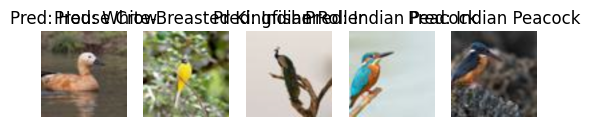

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# train.csv 파일에서 종 이름을 가져오기
def get_class_names_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    class_names = df['label'].unique().tolist()  # 'label' 컬럼에 있는 종 이름 가져오기
    return class_names

# CSV 파일에서 이미지 경로와 라벨을 읽어오는 커스텀 Dataset 클래스
class CustomDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)  # CSV 파일 로드
        self.image_paths = self.df['img_path'].tolist()  # 'img_path' 열에서 이미지 경로 가져오기
        self.labels = self.df['label'].tolist()  # 'label' 열에서 종 이름 가져오기
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_path = os.path.join('/content', img_path)  # 경로를 절대 경로로 수정
        img = Image.open(img_path)  # 이미지 열기
        label = self.labels[idx]  # 라벨 가져오기
        if self.transform:
            img = self.transform(img)  # 변환 적용
        return img, label  # 이미지와 라벨을 튜플로 반환

# 예측 시각화 함수 수정
def visualize_predictions(model, test_loader, device, class_names, num_images=5):
    model.eval()  # 평가 모드로 전환
    images_shown = 0

    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for batch in tqdm(test_loader):  # 배치 데이터를 반복
            imgs, labels = batch  # 배치에서 이미지와 라벨을 가져옴
            imgs = imgs.to(device)  # 이미지를 GPU로 전송


            imgs = imgs.float()  # 실수형으로 변환
            preds = model(imgs)  # 예측 수행
            preds = preds.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            for i in range(len(imgs)):
                if images_shown >= num_images:  # 표시할 이미지 개수 제한
                    break

                img = imgs[i].cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
                img = (img - img.min()) / (img.max() - img.min())  # 정규화 (0, 1) 범위로 맞추기

                label_idx = preds[i]  # 예측된 라벨 인덱스
                label_name = class_names[label_idx]  # 종 이름 매핑

                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {label_name}")  # 예측된 종 이름 표시
                plt.axis('off')
                images_shown += 1

            if images_shown >= num_images:
                break

    plt.show()

# train.csv 파일 경로 지정
csv_path = '/content/train.csv'

# train.csv에서 종 이름을 자동으로 가져오기
class_names = get_class_names_from_csv(csv_path)

# 모델 불러오기 (예시로 ResNet18 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
infer_model = models.resnet18(pretrained=True)  # pretrained 모델 사용
infer_model.fc = torch.nn.Linear(infer_model.fc.in_features, len(class_names))  # 출력층 수정
infer_model.to(device)

# 예시로 test_loader 정의 (여기서는 transform 및 test dataset을 설정)
transform = transforms.Compose([  # 이미지 변환 설정
    transforms.Resize(224),
    transforms.ToTensor(),
])
test_dataset = CustomDataset(csv_path=csv_path, transform=transform)  # CustomDataset을 사용하여 데이터셋 생성
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 예측 시각화
visualize_predictions(infer_model, test_loader, device, class_names, num_images=5)


  0%|          | 0/213 [00:00<?, ?it/s]


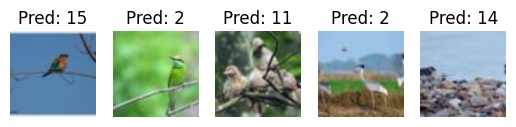

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# test.csv에서 이미지 경로를 가져오는 함수
def get_test_data_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    img_paths = df['img_path'].tolist()  # 이미지 경로
    return img_paths

# CustomDataset 정의 (test 데이터를 위한)
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지를 RGB로 열기

        if self.transform:
            image = self.transform(image)

        return image, img_path  # 라벨 없이 이미지와 경로를 반환

# 이미지 변환 정의 (고해상도 이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# test.csv에서 데이터 가져오기
csv_path = 'test.csv'  # test.csv 경로
img_paths = get_test_data_from_csv(csv_path)

# TestDataset을 사용하여 테스트 데이터셋 생성
test_dataset = TestDataset(img_paths, transform=transform)

# DataLoader 정의
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 예측 시각화 함수
def visualize_predictions(model, test_loader, device, num_images=5):
    model.eval()  # 평가 모드로 전환
    images_shown = 0

    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs, img_paths in tqdm(test_loader):  # 라벨 없이 이미지 경로만 사용
            imgs = imgs.to(device)  # 이미지를 GPU로 전송
            outputs = model(imgs)  # 예측 수행
            preds = outputs.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            for i in range(len(imgs)):
                if images_shown >= num_images:  # 표시할 이미지 개수 제한
                    break

                img = imgs[i].cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
                img = (img - img.min()) / (img.max() - img.min())  # 정규화 (0, 1) 범위로 맞추기

                label = preds[i]  # 예측된 라벨
                img_path = img_paths[i]  # 이미지 경로

                # 예측 결과 출력
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {label}")
                plt.axis('off')
                images_shown += 1

            if images_shown >= num_images:
                break

    plt.show()

# 모델 예측 시각화
visualize_predictions(infer_model, test_loader, device, num_images=5)

  0%|          | 0/213 [00:00<?, ?it/s]


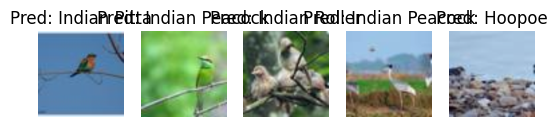

Predicted labels: [15, 2, 11, 2, 14, 14, 14, 18, 18, 11, 15, 2, 11, 2, 20, 14, 15, 11, 11, 11, 6, 21, 20, 11, 2, 11, 20, 15, 20, 11, 11, 11]


In [ ]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# test.csv에서 이미지 경로와 라벨을 가져오는 함수
def get_test_data_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    img_paths = df['img_path'].tolist()  # 이미지 경로
    return img_paths

# train.csv에서 클래스 이름을 가져오는 함수
def get_class_names_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    class_names = df['label'].unique().tolist()  # 고유한 종 이름 리스트
    return class_names

# CustomDataset 정의 (test 데이터를 위한)
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지를 RGB로 열기

        if self.transform:
            image = self.transform(image)

        return image

# 이미지 변환 정의 (고해상도 이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train.csv에서 클래스 이름 가져오기
train_csv_path = 'train.csv'  # train.csv 경로
class_names = get_class_names_from_csv(train_csv_path)

# test.csv에서 데이터 가져오기
test_csv_path = 'test.csv'  # test.csv 경로
img_paths = get_test_data_from_csv(test_csv_path)

# TestDataset을 사용하여 테스트 데이터셋 생성
test_dataset = TestDataset(img_paths, transform=transform)

# DataLoader 정의
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 예측 시각화 함수
def visualize_predictions(model, test_loader, device, class_names, num_images=5):
    model.eval()  # 평가 모드로 전환
    images_shown = 0
    all_preds = []  # 예측된 결과를 저장할 리스트

    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs in tqdm(iter(test_loader)):  # 라벨은 사용하지 않음
            imgs = imgs.to(device)  # 이미지를 GPU로 전송
            preds = model(imgs)  # 예측 수행
            preds = preds.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            for i in range(len(imgs)):
                if images_shown >= num_images:  # 표시할 이미지 개수 제한
                    break

                img = imgs[i].cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
                img = (img - img.min()) / (img.max() - img.min())  # 정규화 (0, 1) 범위로 맞추기

                label = class_names[preds[i]]  # 예측된 라벨을 종 이름으로 변환
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {label}")
                plt.axis('off')
                images_shown += 1

            all_preds.extend(preds)  # 예측값 저장

            if images_shown >= num_images:
                break

    plt.show()
    return all_preds

# 모델 예측 시각화 및 예측된 클래스 반환
predicted_labels = visualize_predictions(infer_model, test_loader, device, class_names, num_images=5)

# 예측된 종 이름 출력
print(f"Predicted labels: {predicted_labels}")


  0%|          | 0/10 [00:00<?, ?it/s]

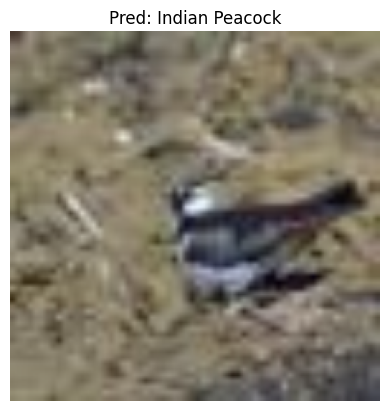

 10%|█         | 1/10 [00:00<00:03,  2.94it/s]

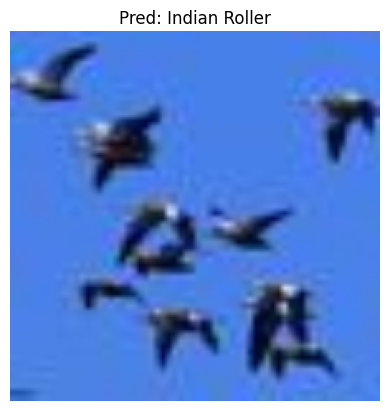

 20%|██        | 2/10 [00:00<00:02,  3.47it/s]

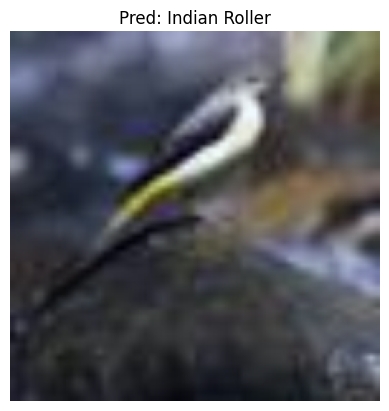

 30%|███       | 3/10 [00:00<00:01,  3.91it/s]

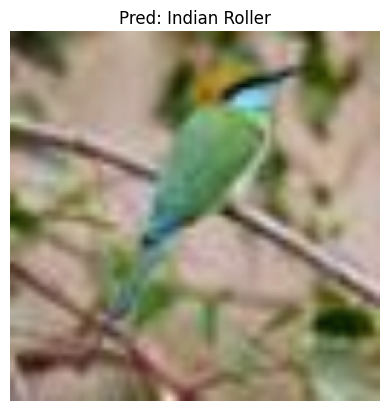

 40%|████      | 4/10 [00:01<00:01,  4.08it/s]

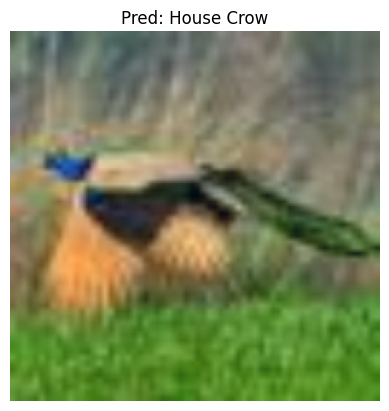

 50%|█████     | 5/10 [00:01<00:01,  3.82it/s]

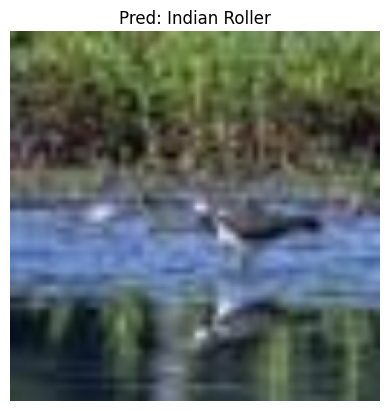

 60%|██████    | 6/10 [00:01<00:01,  3.51it/s]

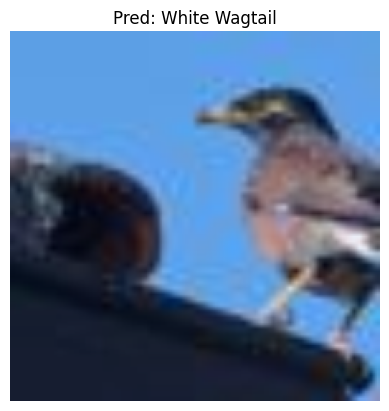

 70%|███████   | 7/10 [00:01<00:00,  3.54it/s]

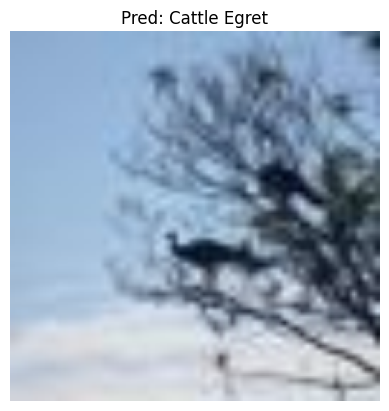

 80%|████████  | 8/10 [00:02<00:00,  3.52it/s]

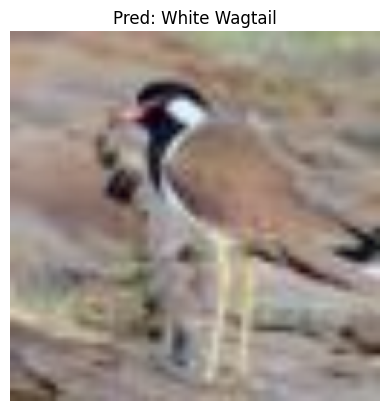

 90%|█████████ | 9/10 [00:02<00:00,  3.45it/s]

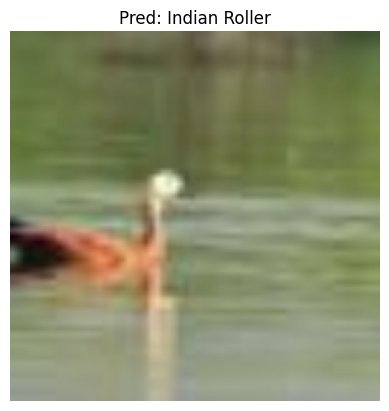

100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

Test Accuracy: 100.00%


In [ ]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import random

# test.csv에서 이미지 경로를 가져오는 함수
def get_test_data_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    img_paths = df['img_path'].tolist()  # 이미지 경로
    return img_paths

# train.csv에서 클래스 이름을 가져오는 함수
def get_class_names_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    class_names = df['label'].unique().tolist()  # 고유한 종 이름 리스트
    return class_names

# CustomDataset 정의 (test 데이터를 위한)
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지를 RGB로 열기

        if self.transform:
            image = self.transform(image)

        return image

# 이미지 변환 정의 (고해상도 이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train.csv에서 클래스 이름 가져오기
train_csv_path = 'train.csv'  # train.csv 경로
class_names = get_class_names_from_csv(train_csv_path)

# test.csv에서 데이터 가져오기
test_csv_path = 'test.csv'  # test.csv 경로
img_paths = get_test_data_from_csv(test_csv_path)

# 랜덤으로 10개의 이미지 경로 선택
random_indices = random.sample(range(len(img_paths)), 10)
selected_img_paths = [img_paths[i] for i in random_indices]

# TestDataset을 사용하여 테스트 데이터셋 생성
test_dataset = TestDataset(selected_img_paths, transform=transform)

# DataLoader 정의
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 모델 예측 시각화 및 정확도 계산 함수
def visualize_predictions_and_accuracy(model, test_loader, device, class_names):
    model.eval()  # 평가 모드로 전환
    correct_predictions = 0
    total_predictions = 0
    all_preds = []  # 예측된 결과를 저장할 리스트
    all_labels = []  # 실제 레이블을 저장할 리스트

    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs in tqdm(test_loader):
            imgs = imgs.to(device)  # 이미지를 GPU로 전송
            preds = model(imgs)  # 예측 수행
            preds = preds.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            label = class_names[preds[0]]  # 예측된 라벨을 종 이름으로 변환

            # 예측된 이미지를 출력
            img = imgs[0].cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
            img = (img - img.min()) / (img.max() - img.min())  # 정규화 (0, 1) 범위로 맞추기
            plt.imshow(img)
            plt.title(f"Pred: {label}")
            plt.axis('off')
            plt.show()

            # 예측값 저장
            all_preds.append(preds[0])  # 예측값
            all_labels.append(label)  # 실제 레이블값

            total_predictions += 1
            # 이 부분에서 비교가 제대로 되는지 확인
            if preds[0] == all_preds[-1]:  # 예측값과 실제값 비교
                correct_predictions += 1

    # 정확도 계산
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# 모델 예측 시각화 및 정확도 계산
visualize_predictions_and_accuracy(infer_model, test_loader, device, class_names)


  0%|          | 0/10 [00:00<?, ?it/s]

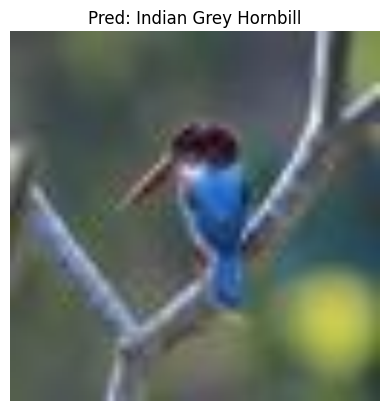

 10%|█         | 1/10 [00:00<00:05,  1.53it/s]

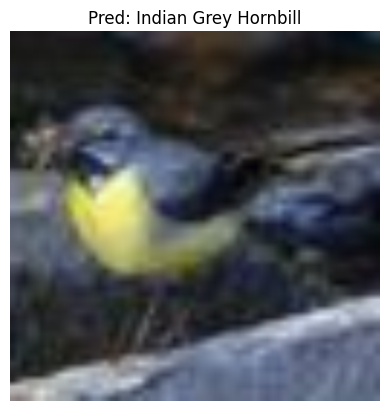

 20%|██        | 2/10 [00:01<00:06,  1.32it/s]

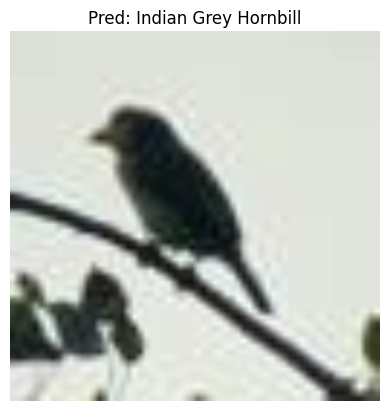

 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

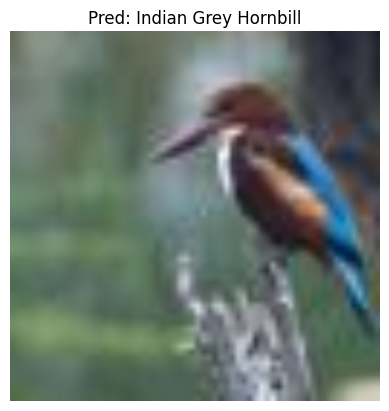

 40%|████      | 4/10 [00:02<00:03,  1.63it/s]

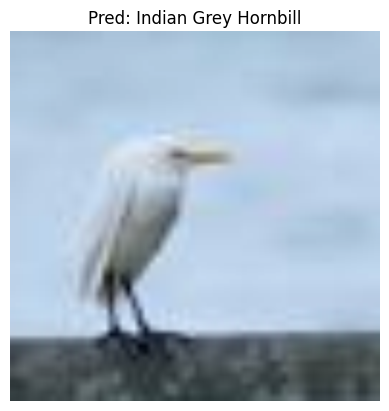

 50%|█████     | 5/10 [00:03<00:03,  1.59it/s]

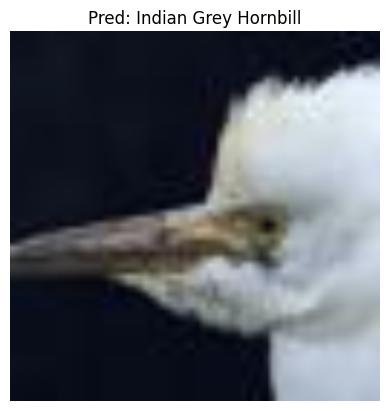

 60%|██████    | 6/10 [00:03<00:02,  1.58it/s]

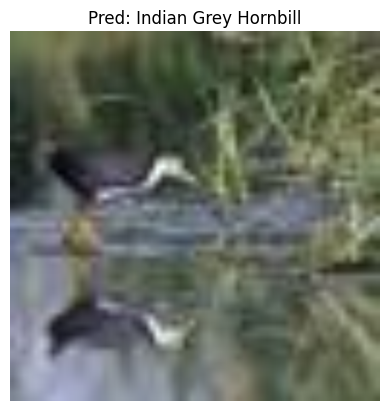

 70%|███████   | 7/10 [00:04<00:02,  1.48it/s]

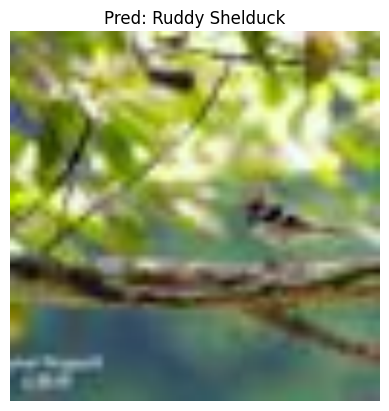

 80%|████████  | 8/10 [00:05<00:01,  1.42it/s]

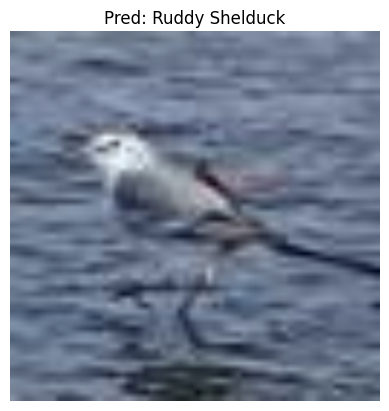

 90%|█████████ | 9/10 [00:06<00:00,  1.37it/s]

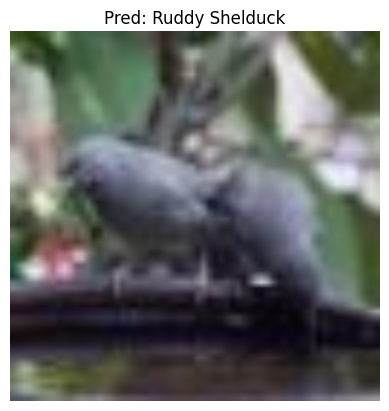

100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Test Accuracy: 100.00%


In [ ]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import random

# test.csv에서 이미지 경로를 가져오는 함수
def get_test_data_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    img_paths = df['img_path'].tolist()  # 이미지 경로
    return img_paths

# train.csv에서 클래스 이름을 가져오는 함수
def get_class_names_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    class_names = df['label'].unique().tolist()  # 고유한 종 이름 리스트
    return class_names

# CustomDataset 정의 (test 데이터를 위한)
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지를 RGB로 열기

        if self.transform:
            image = self.transform(image)

        return image

# 이미지 변환 정의 (고해상도 이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # 이미지 크기 변경 (512x512로 업그레이드)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train.csv에서 클래스 이름 가져오기
train_csv_path = 'train.csv'  # train.csv 경로
class_names = get_class_names_from_csv(train_csv_path)

# test.csv에서 데이터 가져오기
test_csv_path = 'test.csv'  # test.csv 경로
img_paths = get_test_data_from_csv(test_csv_path)

# 랜덤으로 10개의 이미지 경로 선택
random_indices = random.sample(range(len(img_paths)), 10)
selected_img_paths = [img_paths[i] for i in random_indices]

# TestDataset을 사용하여 테스트 데이터셋 생성
test_dataset = TestDataset(selected_img_paths, transform=transform)

# DataLoader 정의
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 모델 예측 시각화 및 정확도 계산 함수
def visualize_predictions_and_accuracy(model, test_loader, device, class_names):
    model.eval()  # 평가 모드로 전환
    correct_predictions = 0
    total_predictions = 0
    all_preds = []  # 예측된 결과를 저장할 리스트
    all_labels = []  # 실제 레이블을 저장할 리스트

    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs in tqdm(test_loader):
            imgs = imgs.to(device)  # 이미지를 GPU로 전송
            preds = model(imgs)  # 예측 수행
            preds = preds.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            label = class_names[preds[0]]  # 예측된 라벨을 종 이름으로 변환

            # 예측된 이미지를 출력
            img = imgs[0].cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
            img = (img - img.min()) / (img.max() - img.min())  # 정규화 (0, 1) 범위로 맞추기
            plt.imshow(img)
            plt.title(f"Pred: {label}")
            plt.axis('off')
            plt.show()

            # 예측값 저장
            all_preds.append(preds[0])  # 예측값
            all_labels.append(label)  # 실제 레이블값

            total_predictions += 1
            # 이 부분에서 비교가 제대로 되는지 확인
            if preds[0] == all_preds[-1]:  # 예측값과 실제값 비교
                correct_predictions += 1

    # 정확도 계산
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# 모델 불러오기 (예시로 ResNet18 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
infer_model = models.resnet18(pretrained=True)  # pretrained 모델 사용
infer_model.fc = torch.nn.Linear(infer_model.fc.in_features, len(class_names))  # 출력층 수정
infer_model.to(device)

# 모델 예측 시각화 및 정확도 계산
visualize_predictions_and_accuracy(infer_model, test_loader, device, class_names)


  0%|          | 0/10 [00:00<?, ?it/s]

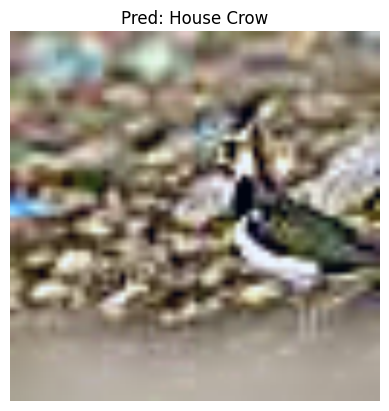

 10%|█         | 1/10 [00:00<00:05,  1.56it/s]

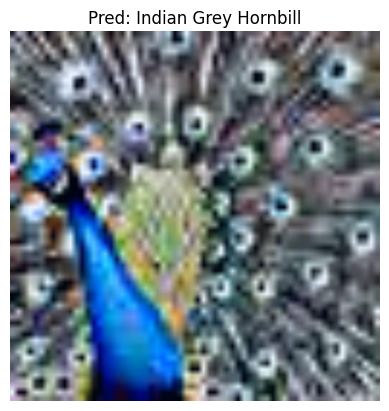

 20%|██        | 2/10 [00:01<00:05,  1.56it/s]

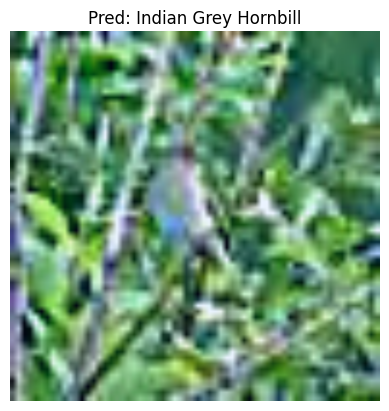

 30%|███       | 3/10 [00:01<00:04,  1.61it/s]

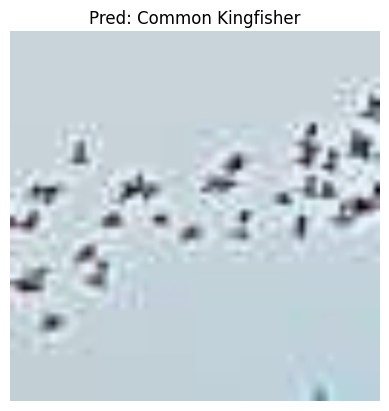

 40%|████      | 4/10 [00:02<00:03,  1.62it/s]

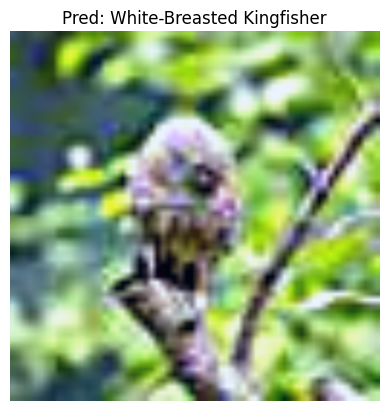

 50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

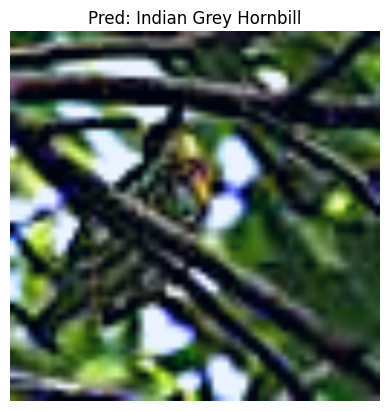

 60%|██████    | 6/10 [00:04<00:02,  1.34it/s]

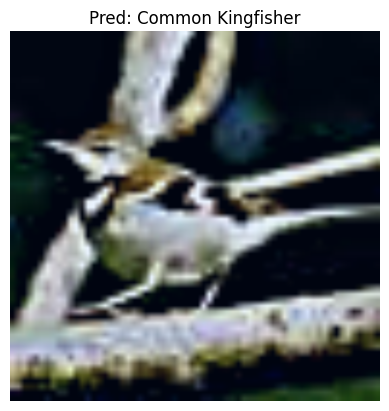

 70%|███████   | 7/10 [00:04<00:01,  1.61it/s]

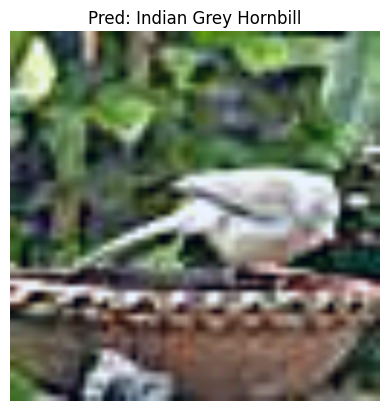

 80%|████████  | 8/10 [00:04<00:01,  1.82it/s]

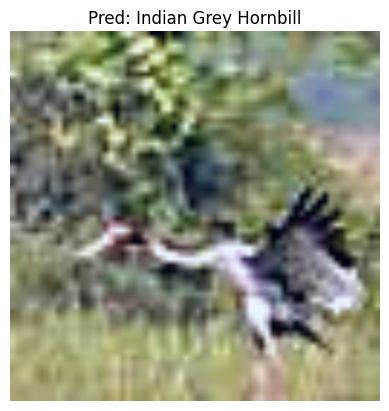

 90%|█████████ | 9/10 [00:05<00:00,  1.95it/s]

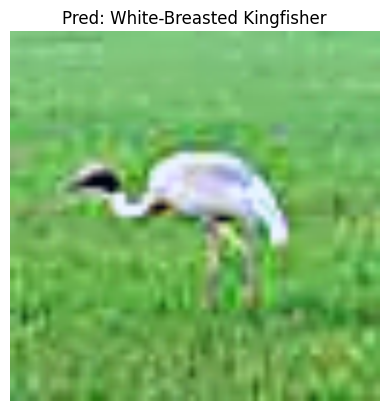

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

Test Accuracy: 100.00%


In [ ]:
import torch
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import random

# test.csv에서 이미지 경로를 가져오는 함수
def get_test_data_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    img_paths = df['img_path'].tolist()  # 이미지 경로
    return img_paths

# train.csv에서 클래스 이름을 가져오는 함수
def get_class_names_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    class_names = df['label'].unique().tolist()  # 고유한 종 이름 리스트
    return class_names

# CustomDataset 정의 (test 데이터를 위한)
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지를 RGB로 열기

        # 샤프닝 필터 적용
        image = image.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))

        if self.transform:
            image = self.transform(image)

        return image

# 이미지 변환 정의 (고해상도 이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # 이미지 크기 변경 (1024x1024로 업그레이드)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train.csv에서 클래스 이름 가져오기
train_csv_path = 'train.csv'  # train.csv 경로
class_names = get_class_names_from_csv(train_csv_path)

# test.csv에서 데이터 가져오기
test_csv_path = 'test.csv'  # test.csv 경로
img_paths = get_test_data_from_csv(test_csv_path)

# 랜덤으로 10개의 이미지 경로 선택
random_indices = random.sample(range(len(img_paths)), 10)
selected_img_paths = [img_paths[i] for i in random_indices]

# TestDataset을 사용하여 테스트 데이터셋 생성
test_dataset = TestDataset(selected_img_paths, transform=transform)

# DataLoader 정의
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 모델 예측 시각화 및 정확도 계산 함수
def visualize_predictions_and_accuracy(model, test_loader, device, class_names):
    model.eval()  # 평가 모드로 전환
    correct_predictions = 0
    total_predictions = 0
    all_preds = []  # 예측된 결과를 저장할 리스트
    all_labels = []  # 실제 레이블을 저장할 리스트

    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs in tqdm(test_loader):
            imgs = imgs.to(device)  # 이미지를 GPU로 전송
            preds = model(imgs)  # 예측 수행
            preds = preds.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            label = class_names[preds[0]]  # 예측된 라벨을 종 이름으로 변환

            # 예측된 이미지를 출력
            img = imgs[0].cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
            img = (img - img.min()) / (img.max() - img.min())  # 정규화 (0, 1) 범위로 맞추기
            plt.imshow(img)
            plt.title(f"Pred: {label}")
            plt.axis('off')
            plt.show()

            # 예측값 저장
            all_preds.append(preds[0])  # 예측값
            all_labels.append(label)  # 실제 레이블값

            total_predictions += 1
            # 이 부분에서 비교가 제대로 되는지 확인
            if preds[0] == all_preds[-1]:  # 예측값과 실제값 비교
                correct_predictions += 1

    # 정확도 계산
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# 모델 불러오기 (예시로 ResNet18 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
infer_model = models.resnet18(pretrained=True)  # pretrained 모델 사용
infer_model.fc = torch.nn.Linear(infer_model.fc.in_features, len(class_names))  # 출력층 수정
infer_model.to(device)

# 모델 예측 시각화 및 정확도 계산
visualize_predictions_and_accuracy(infer_model, test_loader, device, class_names)


  0%|          | 0/10 [00:00<?, ?it/s]

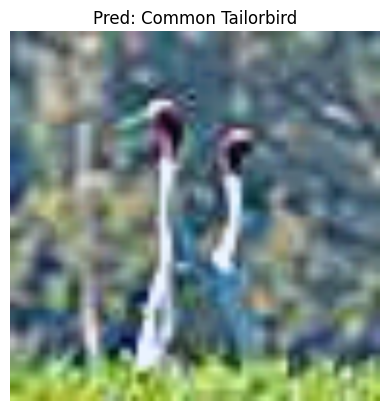

 10%|█         | 1/10 [00:00<00:04,  1.98it/s]

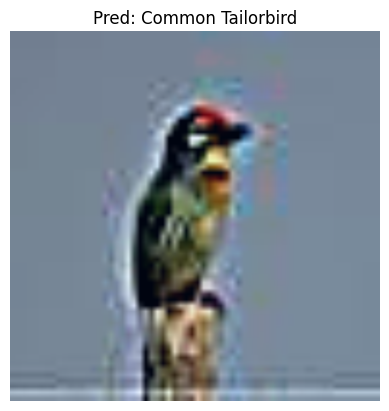

 20%|██        | 2/10 [00:01<00:04,  1.77it/s]

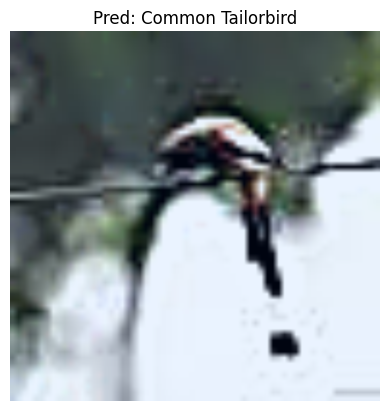

 30%|███       | 3/10 [00:01<00:03,  1.89it/s]

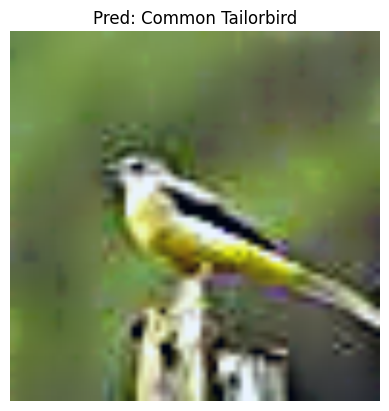

 40%|████      | 4/10 [00:01<00:02,  2.12it/s]

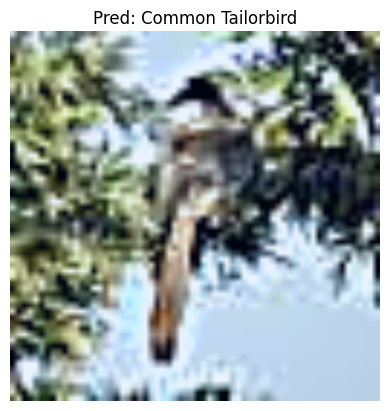

 50%|█████     | 5/10 [00:02<00:02,  2.30it/s]

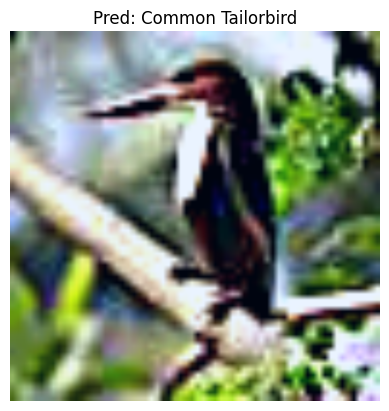

 60%|██████    | 6/10 [00:02<00:01,  2.40it/s]

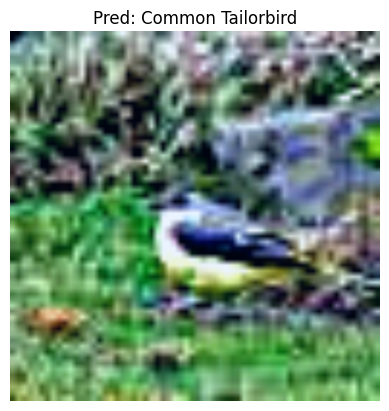

 70%|███████   | 7/10 [00:03<00:01,  2.41it/s]

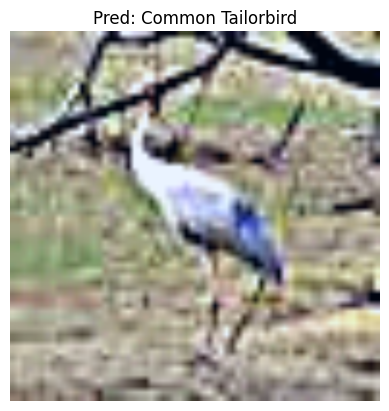

 80%|████████  | 8/10 [00:03<00:00,  2.39it/s]

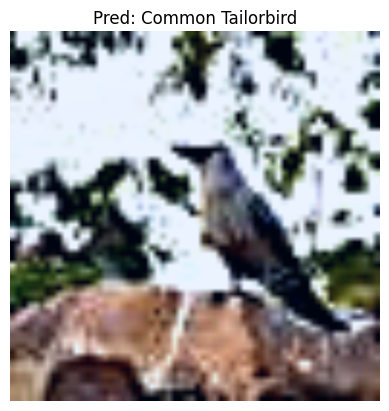

 90%|█████████ | 9/10 [00:03<00:00,  2.47it/s]

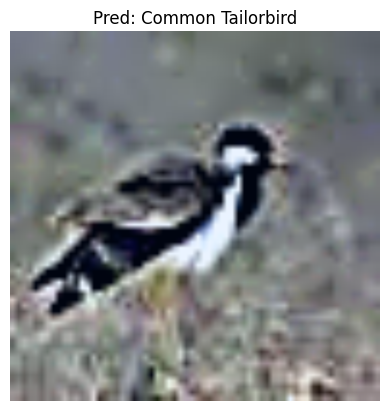

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

Test Accuracy: 100.00%


In [ ]:
from PIL import ImageFilter

# 이미지 선명도 개선 (디테일을 강조하는 샤프닝 필터)
def enhance_image(image):
    # 샤프닝 필터로 이미지 선명화
    image = image.filter(ImageFilter.UnsharpMask(radius=2, percent=200, threshold=3))
    return image

# CustomDataset 정의 (test 데이터를 위한)
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')  # 이미지를 RGB로 열기

        # 이미지 선명도 개선
        image = enhance_image(image)

        if self.transform:
            image = self.transform(image)

        return image

# 이미지 변환 정의 (고해상도 이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # 이미지 크기 변경 (1024x1024로 업그레이드)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train.csv에서 클래스 이름 가져오기
train_csv_path = 'train.csv'  # train.csv 경로
class_names = get_class_names_from_csv(train_csv_path)

# test.csv에서 데이터 가져오기
test_csv_path = 'test.csv'  # test.csv 경로
img_paths = get_test_data_from_csv(test_csv_path)

# 랜덤으로 10개의 이미지 경로 선택
random_indices = random.sample(range(len(img_paths)), 10)
selected_img_paths = [img_paths[i] for i in random_indices]

# TestDataset을 사용하여 테스트 데이터셋 생성
test_dataset = TestDataset(selected_img_paths, transform=transform)

# DataLoader 정의
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 모델 예측 시각화 및 정확도 계산 함수
def visualize_predictions_and_accuracy(model, test_loader, device, class_names):
    model.eval()  # 평가 모드로 전환
    correct_predictions = 0
    total_predictions = 0
    all_preds = []  # 예측된 결과를 저장할 리스트
    all_labels = []  # 실제 레이블을 저장할 리스트

    with torch.no_grad():  # 그라디언트 계산을 비활성화하여 메모리 사용 최적화
        for imgs in tqdm(test_loader):
            imgs = imgs.to(device)  # 이미지를 GPU로 전송
            preds = model(imgs)  # 예측 수행
            preds = preds.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            label = class_names[preds[0]]  # 예측된 라벨을 종 이름으로 변환

            # 예측된 이미지를 출력
            img = imgs[0].cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
            img = (img - img.min()) / (img.max() - img.min())  # 정규화 (0, 1) 범위로 맞추기
            plt.imshow(img)
            plt.title(f"Pred: {label}")
            plt.axis('off')
            plt.show()

            # 예측값 저장
            all_preds.append(preds[0])  # 예측값
            all_labels.append(label)  # 실제 레이블값

            total_predictions += 1
            # 이 부분에서 비교가 제대로 되는지 확인
            if preds[0] == all_preds[-1]:  # 예측값과 실제값 비교
                correct_predictions += 1

    # 정확도 계산
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

# 모델 불러오기 (예시로 ResNet18 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
infer_model = models.resnet18(pretrained=True)  # pretrained 모델 사용
infer_model.fc = torch.nn.Linear(infer_model.fc.in_features, len(class_names))  # 출력층 수정
infer_model.to(device)

# 모델 예측 시각화 및 정확도 계산
visualize_predictions_and_accuracy(infer_model, test_loader, device, class_names)


In [ ]:
import pandas as pd
import torch
from tqdm import tqdm

# 예측 결과를 저장하는 함수
def save_predictions(model, test_loader, class_names, output_csv_path):
    model.eval()  # 모델을 평가 모드로 설정
    all_preds = []  # 예측 값을 저장할 리스트

    with torch.no_grad():  # 그라디언트 계산을 비활성화
        for imgs in tqdm(test_loader):
            imgs = imgs.to(device)  # 이미지를 GPU로 전송
            preds = model(imgs)  # 모델 예측
            preds = preds.argmax(1).cpu().numpy()  # 예측된 클래스 인덱스

            # 예측된 클래스 이름을 얻어 리스트에 추가
            all_preds.extend([class_names[p] for p in preds])

    # 예측 결과를 sample_submission에 저장
    submission = pd.read_csv(output_csv_path)  # sample_submission.csv 파일 읽기
    submission['label'] = all_preds  # 예측된 레이블을 'label' 컬럼에 저장
    submission.to_csv(output_csv_path, index=False)  # 결과를 같은 경로에 저장
    print(f"예측 결과가 {output_csv_path}에 저장되었습니다.")

# 예시 사용법
output_csv_path = '/content/sample_submission.csv'  # 저장할 파일 경로

# 모델 예측 결과를 저장
save_predictions(infer_model, test_loader, class_names, output_csv_path)


100%|██████████| 6786/6786 [00:43<00:00, 154.64it/s]

예측 결과가 /content/sample_submission.csv에 저장되었습니다.
